# Entrega 2: Ejercicio 1 - Análisis descriptivo y preprocesamiento de datos

**Asignatura**: Machine Learning, 2025/2026

**Profesor**: José Tomás Palma Méndez

**Máster de Inteligencia Artificial**
**Autores:**  
- Jesús Guirado Pérez  
- Antonio Luis Sánchez Torres  
- Víctor Emilio Vicente García

**NOTA:** Esto es todo lo que nos ha dado tiempo a hacer hasta el lunes por la noche. Faltan algunas cosas pero tenemos todo lo principal para hacer el feedback de los detalles y decisiones más importantes. Cosas que sabemos que faltan y que pensamos hacer para la entrega final:

* Introducción y conclusiones más detalladas y mejor explicadas
* En general, explicaciones más detalladas sobre el notebook y sobre las decisiones de diseño y entrenamiento de los modelos
* Backtesting en algunos modelos para medir overfitting
* Toda la parte opcional, con los datos climáticos.

Hemos dividido el trabajo en 3 notebooks para no tener que hacer uno excesivamente largo y que sea más rápidos computacionalmente cada vez que queramos ejecutarlos enteros.

# Librerias

Cargamos las librerías que utilizaremos a lo largo del ejercicio.

In [1864]:
# Procesamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose

# Cargamos nuestros datasets

Cargamos los datasets, ``Datos_Energia.csv`` y ``Datos_Climaticos.csv``

In [1865]:
# Cargamos nuestros dos datasets
energia = pd.read_csv("Data/Datos_Energia.csv")
climaticos = pd.read_csv("Data/Datos_Climaticos.csv")

# Análisis de los datasets

Analizamos los dos datasets

In [1866]:
# Información del dataset
energia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78888 entries, 0 to 78887
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Año                  78888 non-null  int64  
 1   Mes                  78888 non-null  int64  
 2   Día                  78888 non-null  int64  
 3   Hora                 78888 non-null  int64  
 4   Día de la semana     78888 non-null  int64  
 5   Electricidad (kW)    78871 non-null  float64
 6   Fotovoltaica (kW)    78871 non-null  float64
 7   Refrigeración (kW)   78871 non-null  float64
 8   Calefacción (kWh)    78871 non-null  float64
 9   Energía total (kWh)  78871 non-null  float64
 10  Emisión (kg CO₂)     78871 non-null  float64
dtypes: float64(6), int64(5)
memory usage: 6.6 MB


Aquí podemos ver cómo tenemos en las 4 primeras variables, datos que podemos utilizar para hacer un "DatetimeIndex" para el dataset ``Datos_Energia.csv``. Además podemos ver que hay 78888 entradas, dónde ninguna variable es no numérica, por lo que no hará falta realizar dummies o onehotencoder. Por último, se pueden ver cómo deberemos hacer también un relleno de nulos, ya que hay columnas (Electricidad (kW), Fotovoltaica (kW), Refrigeración (kW), Calefacción (kWh), Energía total (kWh) y Emisión (kg CO₂)) con 17 valores nulos.

In [1867]:
# Información del dataset
climaticos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78888 entries, 0 to 78887
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Año                         78888 non-null  int64  
 1   Mes                         78888 non-null  int64  
 2   Día                         78888 non-null  int64  
 3   Hora                        78888 non-null  int64  
 4   Día de la semana            78888 non-null  int64  
 5   Temperatura (°C)            78701 non-null  float64
 6   Punto de rocío (°C)         78701 non-null  float64
 7   Humedad (%)                 78701 non-null  float64
 8   Dirección del viento        78355 non-null  object 
 9   Velocidad del viento (m/s)  78701 non-null  float64
 10  Ráfaga de viento (m/s)      78701 non-null  float64
 11  Presión (hPa)               78701 non-null  float64
 12  Precipitación (mm)          78701 non-null  float64
 13  Condición meteorológica     786

Al igual que sucede con el dataset anterior, podemos ver que las 4 primeras columnas se utilizarán para realizar un "DatetimeIndex" para el dataset ``Datos_Climaticos.csv``. Podemos ver como también tenemos 78888 datos, dónde tenemos 2 variables "object", Dirección del viento y Condición meteorológica. Por último, todas las variables excepto las 5 primeras tienen nulos, por lo que también tenemos que tratarlos en este dataset.

# Creamos el DatetimeIndex en nuestros datasets

Vamos a crear nuestro DatetimeIndex que nos será necesario para nuestra práctica de series temporales.

Lo haremos siguiendo la estructura de "Año-Mes-Dia Hora:Minuto:Segundo" por lo que para ello procesaremos las variables Año, Mes, Dia y Hora como strings siguiendo la estructura de antes, además de añadir al final por nosotros mismos los minutos y segundos como ":00:00".

Luego procedemos a eliminar estas variables, por lo que ya no nos serán necesarias una vez que creamos nuestro índice.

In [1868]:
# Creamos un datetime con el año, mes, dia y hora (minutos y segundos lo ponemos a 00 los dos)
energia.index = pd.to_datetime(energia['Año'].astype(str) + '-' + energia['Mes'].astype(str) + '-' + energia['Día'].astype(str) + ' ' + energia['Hora'].astype(str) + ':00:00')
climaticos.index = pd.to_datetime(climaticos['Año'].astype(str) + '-' + climaticos['Mes'].astype(str) + '-' + climaticos['Día'].astype(str) + ' ' + climaticos['Hora'].astype(str) + ':00:00')

# Eliminamos las columnas que hemos utilizado para crear el datetime
energia = energia.drop(columns=['Año', 'Mes', 'Día', 'Hora'])
climaticos = climaticos.drop(columns=['Año', 'Mes', 'Día', 'Hora'])

Comprobamos qué, efectivamente, está hecho el índice de forma correcta y que hemos eliminado las variables de manera correcta.

In [1869]:
# Información del dataset
energia.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78888 entries, 2014-01-01 00:00:00 to 2022-12-31 23:00:00
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Día de la semana     78888 non-null  int64  
 1   Electricidad (kW)    78871 non-null  float64
 2   Fotovoltaica (kW)    78871 non-null  float64
 3   Refrigeración (kW)   78871 non-null  float64
 4   Calefacción (kWh)    78871 non-null  float64
 5   Energía total (kWh)  78871 non-null  float64
 6   Emisión (kg CO₂)     78871 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 4.8 MB


Vemos como el dataset de energía, ya no tiene esas 4 variables y tiene el DatetimeIndex: 78888 entries, 2014-01-01 00:00:00 to 2022-12-31 23:00:00.

In [1870]:
# Información del dataset
climaticos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78888 entries, 2014-01-01 00:00:00 to 2022-12-31 23:00:00
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Día de la semana            78888 non-null  int64  
 1   Temperatura (°C)            78701 non-null  float64
 2   Punto de rocío (°C)         78701 non-null  float64
 3   Humedad (%)                 78701 non-null  float64
 4   Dirección del viento        78355 non-null  object 
 5   Velocidad del viento (m/s)  78701 non-null  float64
 6   Ráfaga de viento (m/s)      78701 non-null  float64
 7   Presión (hPa)               78701 non-null  float64
 8   Precipitación (mm)          78701 non-null  float64
 9   Condición meteorológica     78695 non-null  object 
dtypes: float64(7), int64(1), object(2)
memory usage: 6.6+ MB


En el dataset de climáticos también hemos eliminado las primeras 4 variables y también tiene el DatetimeIndex: 78888 entries, 2014-01-01 00:00:00 to 2022-12-31 23:00:00.

# Fechas perdidas

Comprobamos si tenemos fechas perdidas

In [1871]:
# Se calcula el numero de fechas desde a través de las hora
fechas_esperadas =  pd.date_range(start=energia.index.min(), end=energia.index.max(), freq='h')
# Diferencias entre la cantidad de horas que se supone que tenemos, y lo que realmente tenemos
fechas_perdidas = fechas_esperadas.difference(energia.index)
# Imprimir el número de horas perdidas
print(f'Número de fechas faltantes: {len(fechas_perdidas)}')
# Muestra las horas pérdidas
fechas_perdidas

Número de fechas faltantes: 0


DatetimeIndex([], dtype='datetime64[ns]', freq='h')

Vemos como no tenemos fechas perdidas, por lo que no realizamos nada.

# Datos_Energia

Una vez hecho un análisis general de los dataset, además de crear su "DatetimeIndex", ahora vamos a centrarnos en el dataset de ``Datos_Energia.csv``.

## Tratamiento de duplicados

Primero analizaremos si hay duplicados, y en caso de que los haya eliminarlos

In [1872]:
# Visualizamos la cantidad de duplicados del dataset
energia.duplicated().sum()


np.int64(63)

Vemos como tenemos 63 duplicados, vamos a comprobar si tenemos algún índice duplicado.

In [1873]:
energia.index.duplicated().sum()

np.int64(0)

Vemos como no tenemos índices duplicados, por lo que vamos a sustituir los datos duplicados por nulos, para no eliminar la continuidad de la serie temporal, excepto los días de la semana.

In [1874]:
# Se detectan las filas duplicadas, manteniendo solo la primera de cada grupo de duplicadas
duplicados = energia.duplicated(subset=energia.columns[1:], keep='first')

# Pongo en NaN las filas duplicadas
energia.loc[duplicados, energia.columns[1:]] = np.nan

## Tratamiento de nulos

Vamos a comprobar los nulos que tenemos ahora que hemos tratado los duplicados con nulos.

In [1875]:
# Visualizamos la cantidad de nulos que tiene el dataset
energia.isna().sum()

Día de la semana         0
Electricidad (kW)      138
Fotovoltaica (kW)      138
Refrigeración (kW)     138
Calefacción (kWh)      138
Energía total (kWh)    138
Emisión (kg CO₂)       138
dtype: int64

Como se puede ver hay pocos nulos, por lo que podriamos eliminarlos o imputarlos, en nuestro caso, como no queremos eliminar ya que no queremos perder datos, decidimor imputar, para ello analizamos cómo funciona el dataset

In [1876]:
# Visualizamos las 5 primeras columnas del dataset
energia.head()

Día de la semana  Electricidad (kW)  Fotovoltaica (kW)  \
2014-01-01 00:00:00                 2           21294.33               2.39   
2014-01-01 01:00:00                 2           21190.46               1.95   
2014-01-01 02:00:00                 2           21537.07               4.29   
2014-01-01 03:00:00                 2           21688.66               9.65   
2014-01-01 04:00:00                 2           23044.40              10.19   

                     Refrigeración (kW)  Calefacción (kWh)  \
2014-01-01 00:00:00          8098.10352          876.28229   
2014-01-01 01:00:00          7312.22987          873.35158   
2014-01-01 02:00:00          7305.86410          911.45081   
2014-01-01 03:00:00          7573.82433          870.42087   
2014-01-01 04:00:00          7462.96849          946.61933   

                     Energía total (kWh)  Emisión (kg CO₂)  
2014-01-01 00:00:00          30268.37288           18880.0  
2014-01-01 01:00:00          29377.43704           18320.0  
2014-01-01 02:00:00          29752.56792           18560.0  
2014-01-01 03:00:00          30130.62951           18790.0  
2014-01-01 04:00:00          31455.31043           19620.0

### imputación mediante interpolación temporal

En nuestro dataset, nuestros datos están organizados por horas, por lo que pensamos sacar ventaja sobre ello. Por lo tanto, "method = time" utiliza el DatetimeIndex para estimar los valores faltantes teniendo en cuenta la distancia real entre timestamps (en este caso, horas). Viendo la documentación, vemos como funciona en datos diarios o con mayor resolución, por lo que es adecuado para series horarias como esta. Además, al haber pocos valores nulos, la interpolación temporal proporciona una aproximación suave y coherente sin distorsionar el comportamiento general de la serie.

In [1877]:
# Seleccionamos todas las columnas numéricas del dataset
numericas = energia.select_dtypes(include='number').columns
# Utilizamos interpolación temporal en el dataset en las columnas seleccionadas
energia[numericas] = energia[numericas].interpolate(method='time')

Comprobamos si siguen existiendo más nulos.

In [1878]:
# Visualizamos la cantidad de nulos que tiene el dataset
energia.isna().sum()

Día de la semana       0
Electricidad (kW)      0
Fotovoltaica (kW)      0
Refrigeración (kW)     0
Calefacción (kWh)      0
Energía total (kWh)    0
Emisión (kg CO₂)       0
dtype: int64

Podemos ver como ya no existen más nulos.

## Outliers

Vamos a analizar si hay valores sospechosos en cada una de las variables. Primero, analizaremos los 5 primeros datos de nuestro dataset.

In [1879]:
# Visualizamos las 5 primeras columnas del dataset
energia.head()

Día de la semana  Electricidad (kW)  Fotovoltaica (kW)  \
2014-01-01 00:00:00                 2           21294.33               2.39   
2014-01-01 01:00:00                 2           21190.46               1.95   
2014-01-01 02:00:00                 2           21537.07               4.29   
2014-01-01 03:00:00                 2           21688.66               9.65   
2014-01-01 04:00:00                 2           23044.40              10.19   

                     Refrigeración (kW)  Calefacción (kWh)  \
2014-01-01 00:00:00          8098.10352          876.28229   
2014-01-01 01:00:00          7312.22987          873.35158   
2014-01-01 02:00:00          7305.86410          911.45081   
2014-01-01 03:00:00          7573.82433          870.42087   
2014-01-01 04:00:00          7462.96849          946.61933   

                     Energía total (kWh)  Emisión (kg CO₂)  
2014-01-01 00:00:00          30268.37288           18880.0  
2014-01-01 01:00:00          29377.43704           18320.0  
2014-01-01 02:00:00          29752.56792           18560.0  
2014-01-01 03:00:00          30130.62951           18790.0  
2014-01-01 04:00:00          31455.31043           19620.0

Se puede ver de primeras que "Punto de rocío (ºC)" se comporta de manera sospechosa con muchos valores negativos de -17.777778, por lo que vamos a analizar nuestras variables a través de un boxplot.

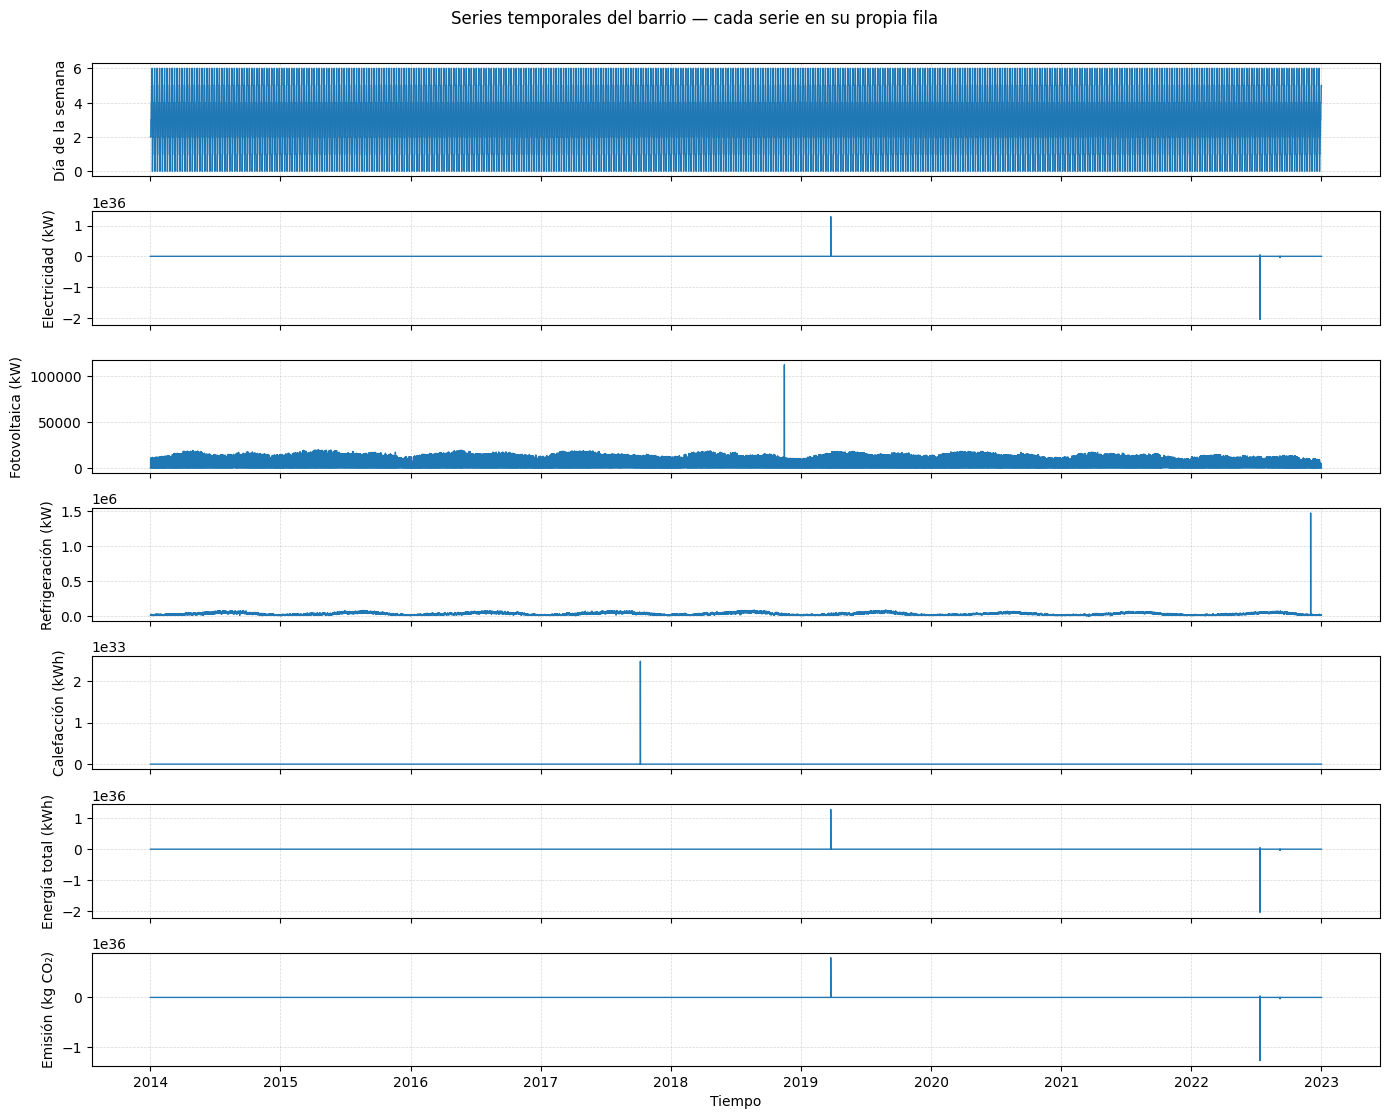

In [1880]:
# Guarda el número de variables del dataset
n = len(energia.columns)
# Creamos las figuras y ejes con 1 columna que cada fila tendrá una variable, en figsize poniendo anchura y altura, comparten el mismo eje x
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(14, max(2, 1.6 * n)), sharex=True)
# Dibuja la serie temporal de cada columna, pone su nombre al eje y y coloca un grid
for ax, col in zip(axes, energia.columns):
    ax.plot(energia.index, energia[col], linewidth=1)
    ax.set_ylabel(col)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
# Coloca en la última gráfica el eje X
axes[-1].set_xlabel("Tiempo")
# Nombre general
fig.suptitle("Series temporales del barrio — cada serie en su propia fila", y=0.995)
# Distancia entre filas
plt.tight_layout(rect=[0, 0, 1, 0.99])
# Se muestra la gráfica
plt.show()


Hablaremos de lo que vemos a simple vista, por lo tanto hablaremos de muchos números como estimación y no como valor exacto, pero suficiente para entender como funciona cada variable:

Día de la semana: Se puede ver que hay una estacionalidad, puesto que no se equivoca y no puede cambiar ni en el presente ni en el futuro.

Electricidad (kW): Se puede ver que tiene una escalda de 1e36, haciendo que al estar todos los valores en 0 da a entender que hay una desproporción entre los datos y los outliers, ya que todos los valores están alrededor de 0 y unos pocos a 1e36, y otros a -2e36

Fotovoltaica (kW): Todos los datos están entre 0 y 25000, y algunos datos suben disparados a 100000, dando presencia de outliers.

Refrigeración (kW): Sucede como en la variable Electricidad (kW), todos los datos alrededor de 0, y algunos datos a 1.5e36, por lo que estos outliers están desproporcionadamente por encima de los datos de la variable

Calefacción (kWh): Tiene los datos alrededor de 0 y algunos a 2e33, pudiéndose ver de nuevo, outliers exageradamente desproporcionadamente grandes.

Energía total (kWh): Al ser la suma total de Electricidad (kW), Refrigeración (kWh) y Calefacción (kWh), y estas 3 tienen outliers, esta variable también tendrá outliers, y como puede verse en la gráfica, se ven iguales que Electricidad (kW), seguramente debido a que la escala de outliers es la más grande con 1e36 y -2e36.

Emisión (kg CO₂): Al igual que con muchas variables del dataset, todos los valores alrededor de 0 y pocos valores a 0.5e36 y otros a -1e36, debido a la desproporción de la escala de los outliers.

Ahora vamos a analizar las variables de una en una, excepto los días de la semana, que como hemos visto, es estacional.

### Electricidad (kW)

Como hemos indicado anteriormente, en esta variable hay outliers tan enormes que visualmente parece que hay una linea en la gráfica que está en 0. Vamos a revisar como están distribuidos sus valores.

In [1881]:
# Visualizamos minimo, maximo, media, desviación típica, 25%, 50%, 75% y el número de valores que tiene la variable
print(energia['Electricidad (kW)'].describe())


count    7.888800e+04
mean    -3.529852e+31
std      1.127725e+34
min     -2.050000e+36
25%      2.168175e+04
50%      2.515035e+04
75%      2.915754e+04
max      1.290000e+36
Name: Electricidad (kW), dtype: float64


Podemos ver como hay datos con valores excesivamente altos y bajos que no tienen sentido en la variable, por lo tanto establecemos percentiles para solamente eliminar los datos excesivos.

In [1882]:
# establecemos los percentiles
cuartil_minimo = energia['Electricidad (kW)'].quantile(0.003)
cuartil_maximo = energia['Electricidad (kW)'].quantile(0.999)

# Conservamos únicamente los datos en los cuales hemos establecido los límites
energia['Electricidad (kW)'] = energia['Electricidad (kW)'].where(
    (energia['Electricidad (kW)'] >= cuartil_minimo) & (energia['Electricidad (kW)'] <= cuartil_maximo)
)


Ajustamos para intentar eliminar valores excesivos y otros valores que bajen o suban y que no tengan sentido. Comprobamos cuántos valores hemos eliminado.

In [1883]:
# Visualizamos la cantidad de nulos que tiene el dataset
energia.isna().sum()

Día de la semana         0
Electricidad (kW)      316
Fotovoltaica (kW)        0
Refrigeración (kW)       0
Calefacción (kWh)        0
Energía total (kWh)      0
Emisión (kg CO₂)         0
dtype: int64

hemos eliminado 316 valores, los cuáles constituye un ~0.4% del dataset, lo que debería ser una pequeña cantidad para eliminar los outliers.

Utilizamos el método que utilizamos para los nulos de antes con el interpolado temporal, haciendo que queden valores más lógicos.

In [1884]:
# Utilizamos interpolación temporal en el dataset en las columnas seleccionadas
energia['Electricidad (kW)'] = energia['Electricidad (kW)'].interpolate(method='time')

Aquí podemos ver cómo han quedado los datos después del interpolado temporal.

In [1885]:
# Visualizamos minimo, maximo, media, desviación típica, 25%, 50%, 75% y el número de valores que tiene la variable
energia['Electricidad (kW)'].describe()

count    78888.000000
mean     25705.489578
std       5426.558286
min      14559.810000
25%      21682.067500
50%      25146.860000
75%      29148.477500
max      43837.690000
Name: Electricidad (kW), dtype: float64

Se puede ver un mínimo de 14559, un máximo de 42837, una mediana de 25146 y una desviación típica de 5426.

Ahora vamos a analizar la gráfica.

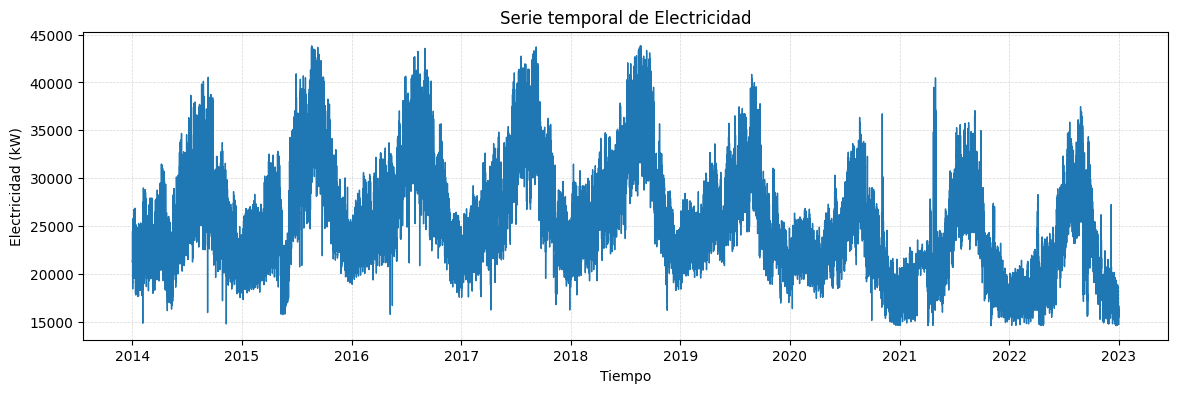

In [1886]:
# Creamos la gráfica de anchura 14, altura 4
fig, ax = plt.subplots(figsize=(14, 4))
# Pasamos las columnas que queremos representar
ax.plot(energia.index, energia['Electricidad (kW)'], linewidth=1)
# Nombre de la columna en el eje y
ax.set_ylabel('Electricidad (kW)')
# Nombre de la columna en el eje x
ax.set_xlabel('Tiempo')
# Nombre de la grafica
ax.set_title('Serie temporal de Electricidad')
# Grid de la gráfica
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
# Imprime la gráfica
plt.show()


Vemos como los valores parecen ir desde alrededor de 14000 a alrededor de 43000, valores más típicos para el contexto del problema, además de que se puede ver la representación de la gráfica sin valores "aplastados".

### Fotovoltaica (kW)

Vamos a analizar la variable Fotovoltaica (kW)

In [1887]:
# Visualizamos minimo, maximo, media, desviación típica, 25%, 50%, 75% y el número de valores que tiene la variable
print(energia['Fotovoltaica (kW)'].describe())

count     78888.000000
mean       3969.528244
std        5307.698582
min           0.000000
25%           3.880000
50%         160.675000
75%        8396.062500
max      111938.620000
Name: Fotovoltaica (kW), dtype: float64


Se puede ver, cómo el mínimo es de 0, 25% 3.88, 50% 160.675, 75% 8396.0625 y max 111938.62, por lo que se ve lo que hemos visto en la gráfica, que hay outliers muy altos que debemos eliminar, para ello utilizaremos el mismo proceso que la anterior variable pero sin tener en cuenta el percentil inferior.

In [1888]:
# establecemos los percentiles
cuartil_maximo = energia['Fotovoltaica (kW)'].quantile(0.9999)

# Conservamos únicamente los datos en los cuales hemos establecido los límites
energia['Fotovoltaica (kW)'] = energia['Fotovoltaica (kW)'].where((energia['Fotovoltaica (kW)'] <= cuartil_maximo)
)


Una vez eliminado únicamente los outliers, revisamos cuántos outliers hemos eliminado.

In [1889]:
# Visualizamos la cantidad de nulos que tiene el dataset
energia.isna().sum()

Día de la semana       0
Electricidad (kW)      0
Fotovoltaica (kW)      8
Refrigeración (kW)     0
Calefacción (kWh)      0
Energía total (kWh)    0
Emisión (kg CO₂)       0
dtype: int64

Hemos eliminado 8 outliers. Ahora vamos a hacer un interpolado temporal para rellenar nulos siguiendo la distribución de la gráfica.

In [1890]:
# Utilizamos interpolación temporal en el dataset en las columnas seleccionadas
energia['Fotovoltaica (kW)'] = energia['Fotovoltaica (kW)'].interpolate(method='time')

Revisamos cómo han quedado los datos despés del interpolado temporal.

In [1891]:
# Visualizamos minimo, maximo, media, desviación típica, 25%, 50%, 75% y el número de valores que tiene la variable
print(energia['Fotovoltaica (kW)'].describe())

count    78888.000000
mean      3967.392042
std       5288.971566
min          0.000000
25%          3.880000
50%        160.675000
75%       8394.950000
max      19026.650000
Name: Fotovoltaica (kW), dtype: float64


Vemos como ya no queda nulos, y la variable parece tener valores más normales, entre 0 y 19026, ahora vamos a revisarlo con una gráfica.

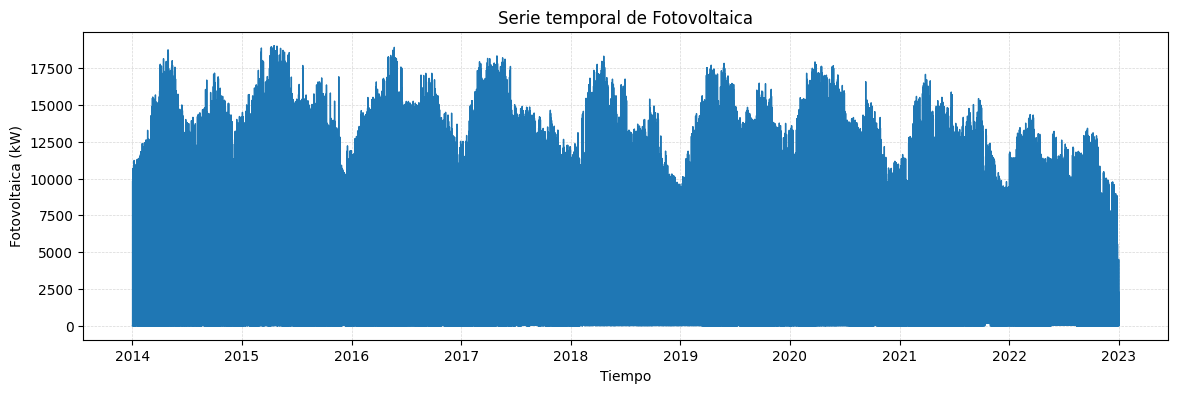

In [1892]:
# Creamos la gráfica de anchura 14, altura 4
fig, ax = plt.subplots(figsize=(14, 4))
# Pasamos las columnas que queremos representar
ax.plot(energia.index, energia['Fotovoltaica (kW)'], linewidth=1)
# Nombre de la columna en el eje y
ax.set_ylabel('Fotovoltaica (kW)')
# Nombre de la columna en el eje x
ax.set_xlabel('Tiempo')
# Nombre de la grafica
ax.set_title('Serie temporal de Fotovoltaica')
# Grid de la gráfica
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
# Imprime la gráfica
plt.show()

Se puede ver cómo si hubieramos hecho zoom a la gráfica que habíamos visto al principio pero sin los outliers, por lo tanto se ve como que todos los outliers han sido eliminados de forma definitiva.

### Refrigeración (kW)

Analizamos la variable Refrigeración (kW).

In [1893]:
# Visualizamos minimo, maximo, media, desviación típica, 25%, 50%, 75% y el número de valores que tiene la variable
print(energia['Refrigeración (kW)'].describe())

count    7.888800e+04
mean     2.952204e+04
std      1.725338e+04
min      0.000000e+00
25%      1.550072e+04
50%      2.629214e+04
75%      4.134471e+04
max      1.468215e+06
Name: Refrigeración (kW), dtype: float64


Aquí se puede ver, una vez más, que el valor máximo es un número mucho más grande que el resto de valores, indicando que hay outliers hacia arriba, por lo tanto aplicaremos la misma metodología de la variable anterior.

Para ello eliminaremos (sustituidos por nulos) todos los datos que esten por encima del percentil que esblacemos, para deshacernos de los outliers.

In [1894]:
# establecemos los percentiles
cuartil_maximo = energia['Refrigeración (kW)'].quantile(0.9999)

# Conservamos únicamente los datos en los cuales hemos establecido los límites
energia['Refrigeración (kW)'] = energia['Refrigeración (kW)'].where((energia['Refrigeración (kW)'] <= cuartil_maximo)
)


Comprobamos cuántos nulos tiene nuestro dataset al eliminar los outliers.

In [1895]:
# Visualizamos la cantidad de nulos que tiene el dataset
energia.isna().sum()

Día de la semana       0
Electricidad (kW)      0
Fotovoltaica (kW)      0
Refrigeración (kW)     8
Calefacción (kWh)      0
Energía total (kWh)    0
Emisión (kg CO₂)       0
dtype: int64

Se ve cómo hemos eliminado 8 outliers, ahora realizaremos la imputacion por interpolación temporal, como hicimos en la variable anterior.

In [1896]:
# Utilizamos interpolación temporal en el dataset en las columnas seleccionadas
energia['Refrigeración (kW)'] = energia['Refrigeración (kW)'].interpolate(method='time')

Ahora comprobamos como ha quedado nuestra variable.

In [1897]:
# Visualizamos minimo, maximo, media, desviación típica, 25%, 50%, 75% y el número de valores que tiene la variable
print(energia['Refrigeración (kW)'].describe())

count    78888.000000
mean     29496.163475
std      16346.803327
min          0.000000
25%      15500.720290
50%      26291.456595
75%      41343.434062
max      80437.553190
Name: Refrigeración (kW), dtype: float64


Se puede ver cómo todos los nulos han sido sustituidos por los valores de interpolación temporal (tenemos 7888 valores no nulos) y como el valor máximo es un valor más lógico con el del dataset.

Ahora revisaremos como se ve en la gráfica.

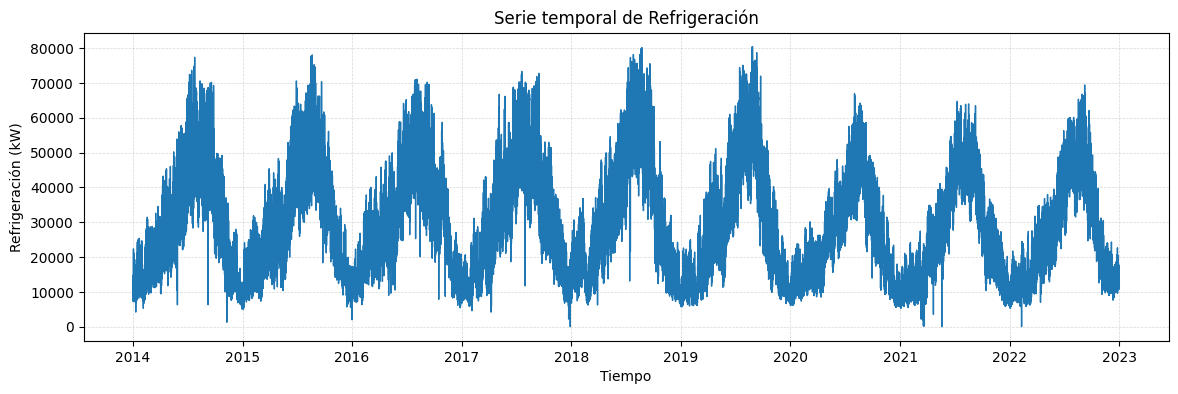

In [1898]:
# Creamos la gráfica de anchura 14, altura 4
fig, ax = plt.subplots(figsize=(14, 4))
# Pasamos las columnas que queremos representar
ax.plot(energia.index, energia['Refrigeración (kW)'], linewidth=1)
# Nombre de la columna en el eje y
ax.set_ylabel('Refrigeración (kW)')
# Nombre de la columna en el eje x
ax.set_xlabel('Tiempo')
# Nombre de la grafica
ax.set_title('Serie temporal de Refrigeración')
# Grid de la gráfica
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
# Imprime la gráfica
plt.show()

se puede ver como hay algunas bajadas sospechosas en la gráfica, pero no lo vemos lo suficientemente graves para tener que tratarlas.

### Calefacción (kWh)

Analizamos la variable Calefacción (kWh).

In [1899]:
# Visualizamos minimo, maximo, media, desviación típica, 25%, 50%, 75% y el número de valores que tiene la variable
print(energia['Calefacción (kWh)'].describe())

count    7.888800e+04
mean     3.135633e+28
std      8.806631e+30
min     -2.930710e+00
25%      1.462424e+03
50%      1.828763e+03
75%      2.614193e+03
max      2.473519e+33
Name: Calefacción (kWh), dtype: float64


Podemos ver cómo el valor máximo es demasiado alto e irreal, y el número mínimo es negativo cuando no tiene sentido en el contexto del problema, por lo que procedemos a eliminarlos, con el método de los percentiles, tanto superior como inferior.

In [1900]:
# establecemos los percentiles
cuartil_minimo = energia['Calefacción (kWh)'].quantile(0.0001)
cuartil_maximo = energia['Calefacción (kWh)'].quantile(0.999)

# Conservamos únicamente los datos en los cuales hemos establecido los límites
energia['Calefacción (kWh)'] = energia['Calefacción (kWh)'].where(
    (energia['Calefacción (kWh)'] >= cuartil_minimo) & (energia['Calefacción (kWh)'] <= cuartil_maximo)
)


Ahora revisaremos la cantidad de outliers que hemos eliminado.

In [1901]:
# Visualizamos la cantidad de nulos que tiene el dataset
energia.isna().sum()

Día de la semana        0
Electricidad (kW)       0
Fotovoltaica (kW)       0
Refrigeración (kW)      0
Calefacción (kWh)      85
Energía total (kWh)     0
Emisión (kg CO₂)        0
dtype: int64

Se ve que hemos eliminado únicamente 85 outliers, para rellenar nulos utilizaremos la interpolación temporal.

In [1902]:
# Utilizamos interpolación temporal en el dataset en las columnas seleccionadas
energia['Calefacción (kWh)'] = energia['Calefacción (kWh)'].interpolate(method='time')

Ahora veremos como ha quedado el dataset después del interpolado temporal.

In [1903]:
# Visualizamos minimo, maximo, media, desviación típica, 25%, 50%, 75% y el número de valores que tiene la variable
energia['Calefacción (kWh)'].describe()

count    78888.000000
mean      2162.191635
std       1037.543775
min          0.000000
25%       1462.424290
50%       1828.763040
75%       2614.193320
max       8370.107760
Name: Calefacción (kWh), dtype: float64

Podemos ver cómo ya no quedan nulos y como todos los valores parecen aceptables, ahora revisaremos la gráfica.

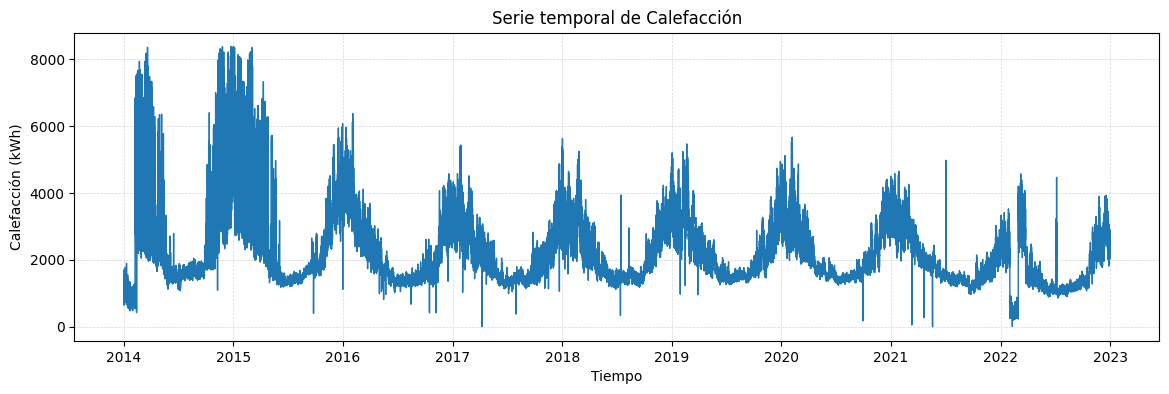

In [1904]:
# Creamos la gráfica de anchura 14, altura 4
fig, ax = plt.subplots(figsize=(14, 4))
# Pasamos las columnas que queremos representar
ax.plot(energia.index, energia['Calefacción (kWh)'], linewidth=1)
# Nombre de la columna en el eje y
ax.set_ylabel('Calefacción (kWh)')
# Nombre de la columna en el eje x
ax.set_xlabel('Tiempo')
# Nombre de la grafica
ax.set_title('Serie temporal de Calefacción')
# Grid de la gráfica
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
# Imprime la gráfica
plt.show()


Se puede ver cómo la gráfica muestra un comportamiento correcto.

### Energía total (kWh)

Vamos a analizar la variable Energía total.

In [1905]:
# Visualizamos minimo, maximo, media, desviación típica, 25%, 50%, 75% y el número de valores que tiene la variable
print(energia['Energía total (kWh)'].describe())

count    7.888800e+04
mean    -3.528571e+31
std      1.127948e+34
min     -2.051497e+36
25%      4.059326e+04
50%      5.309860e+04
75%      7.177602e+04
max      1.289512e+36
Name: Energía total (kWh), dtype: float64


Como podemos ver en el enunciado de la práctica, "Energía total (kWh)" es la suma total de las variables "Electricidad (kW)", "Refrigeración (kW)" y "Calefacción (kWh)", por lo que trataremos los outliers con la suma de estas 3 variables.

In [1906]:
# Suma de variables por filas
energia['Energía total (kWh)'] = (
    energia['Electricidad (kW)'] +
    energia['Refrigeración (kW)'] +
    energia['Calefacción (kWh)']
)

Una vez calculada, comprobaremos como ha quedado nuestra variable.

In [1907]:
# Visualizamos minimo, maximo, media, desviación típica, 25%, 50%, 75% y el número de valores que tiene la variable
energia['Energía total (kWh)'].describe()

count     78888.000000
mean      57363.844687
std       20443.066866
min       17624.088000
25%       40598.833575
50%       53080.711905
75%       71725.689493
max      125635.475740
Name: Energía total (kWh), dtype: float64

Vemos cómo nuestro dataset ya contiene valores aceptables. Ahora veremos su representación de su serie temporal en una gráfica.

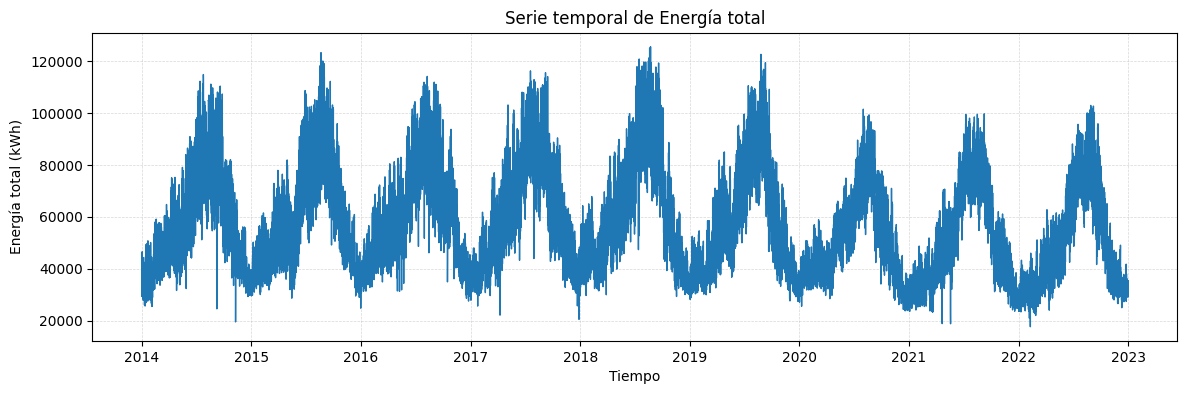

In [1908]:
# Creamos la gráfica de anchura 14, altura 4
fig, ax = plt.subplots(figsize=(14, 4))
# Pasamos las columnas que queremos representar
ax.plot(energia.index, energia['Energía total (kWh)'], linewidth=1)
# Nombre de la columna en el eje y
ax.set_ylabel('Energía total (kWh)')
# Nombre de la columna en el eje x
ax.set_xlabel('Tiempo')
# Nombre de la grafica
ax.set_title('Serie temporal de Energía total')
# Grid de la gráfica
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
# Imprime la gráfica
plt.show()


Vemos como la gráfica parece funcionar de manera correcta.

### Emisión (kg CO₂)

Vamos a analizar como funciona la variable.

In [1909]:
# Visualizamos minimo, maximo, media, desviación típica, 25%, 50%, 75% y el número de valores que tiene la variable
print(energia['Emisión (kg CO₂)'].describe())

count    7.888800e+04
mean    -2.197952e+31
std      7.032121e+33
min     -1.280000e+36
25%      2.532000e+04
50%      3.312000e+04
75%      4.476000e+04
max      8.050000e+35
Name: Emisión (kg CO₂), dtype: float64


Vemos como tenemos unos datos extremadamente grandes y extremadamente negativos, cuando la variable no tiene sentido este tipo de datos, por lo que estableceremos percentiles superior e inferior para tratar con los datos.

In [1910]:
# establecemos los percentiles
cuartil_minimo = energia['Emisión (kg CO₂)'].quantile(0.002)
cuartil_maximo = energia['Emisión (kg CO₂)'].quantile(0.999)

# Conservamos únicamente los datos en los cuales hemos establecido los límites
energia['Emisión (kg CO₂)'] = energia['Emisión (kg CO₂)'].where(
    (energia['Emisión (kg CO₂)'] >= cuartil_minimo) & (energia['Emisión (kg CO₂)'] <= cuartil_maximo)
)

Comprobamos la cantidad de outliers detectados y eliminados.

In [1911]:
# Visualizamos la cantidad de nulos que tiene el dataset
energia.isna().sum()

Día de la semana         0
Electricidad (kW)        0
Fotovoltaica (kW)        0
Refrigeración (kW)       0
Calefacción (kWh)        0
Energía total (kWh)      0
Emisión (kg CO₂)       237
dtype: int64

vemos como tenemos 237 elementos que hemos eliminado, por lo que ahora imputaremos por interpolación temporal.

In [1912]:
# Utilizamos interpolación temporal en el dataset en las columnas seleccionadas
energia['Emisión (kg CO₂)'] = energia['Emisión (kg CO₂)'].interpolate(method='time')

Vemos como ha quedado el dataset y si han quedado algún nulo sin rellenar.

In [1913]:
# Visualizamos minimo, maximo, media, desviación típica, 25%, 50%, 75% y el número de valores que tiene la variable
energia['Emisión (kg CO₂)'].describe()

count    78888.000000
mean     35788.231184
std      12745.103364
min      13780.000000
25%      25340.000000
50%      33120.000000
75%      44750.000000
max      74540.000000
Name: Emisión (kg CO₂), dtype: float64

Vemos cómo no hay nulos y sus datos tienen valores lógicos con el resto de valores de la variable. Ahora veremos su representación temporal en una gráfica.

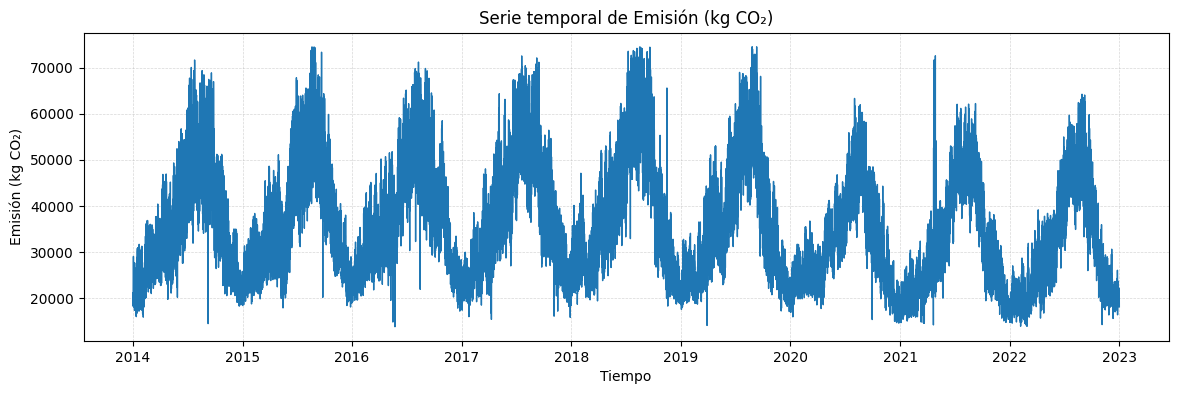

In [1914]:
# Creamos la gráfica de anchura 14, altura 4
fig, ax = plt.subplots(figsize=(14, 4))
# Pasamos las columnas que queremos representar
ax.plot(energia.index, energia['Emisión (kg CO₂)'], linewidth=1)
# Nombre de la columna en el eje y
ax.set_ylabel('Emisión (kg CO₂)')
# Nombre de la columna en el eje x
ax.set_xlabel('Tiempo')
# Nombre de la grafica
ax.set_title('Serie temporal de Emisión (kg CO₂)')
# Grid de la gráfica
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
# Imprime la gráfica
plt.show()


Vemos como la gráfica por lo general funciona bastante bien.

## Transformacion a días

Ante la gran cantidad de datos y que nuestro dataset no tiene mucho sentido que tenga los datos en formato horario, decidimos cambiarlo a que sean diarios. Para ello, hacemos un resample diario que sume todos los datos de cada dia, pero teniendo en cuenta que "Día de la semana" no queremos que cambie, y como cada fila es la suma de si mismo 24 veces, decidimos hacer una división de 24 y transformarlo en entero.

In [1915]:
# Cambia frecuencia temporal
energia = energia.resample('D').sum()
# Divide entre 24 los datos de la variable
energia['Día de la semana'] = energia['Día de la semana']/24
# Transforma a entero la variable
energia['Día de la semana'] = energia['Día de la semana'].astype(int)

Revisamos como han quedado las 10 primeras filas.

In [1916]:
# Visualizamos las 5 primeras columnas del dataset
energia.head(10)

Día de la semana  Electricidad (kW)  Fotovoltaica (kW)  \
2014-01-01                 2          490049.28           62795.47   
2014-01-02                 3          556486.56           64284.00   
2014-01-03                 4          545831.45           67187.06   
2014-01-04                 5          511495.56           46798.28   
2014-01-05                 6          502806.80           70162.87   
2014-01-06                 0          543968.35           71666.60   
2014-01-07                 1          562002.91           52517.04   
2014-01-08                 2          557214.72           66145.06   
2014-01-09                 3          563161.10           50888.52   
2014-01-10                 4          520356.53           62773.62   

            Refrigeración (kW)  Calefacción (kWh)  Energía total (kWh)  \
2014-01-01        243369.71770        20107.60131         753526.59901   
2014-01-02        323886.05169        23987.86135         904360.47304   
2014-01-03        337004.60237        22112.20695         904948.25932   
2014-01-04        252493.06189        21074.73561         785063.35750   
2014-01-05        249265.37031        22777.47812         774849.64843   
2014-01-06        285299.00483        27314.21720         856581.57203   
2014-01-07        274781.34599        23633.24544         860417.50143   
2014-01-08        265609.15067        24020.09916         846843.96983   
2014-01-09        243592.34380        23108.64835         829862.09215   
2014-01-10        235918.63667        22238.22748         778513.39415   

            Emisión (kg CO₂)  
2014-01-01          469960.0  
2014-01-02          564020.0  
2014-01-03          564390.0  
2014-01-04          489640.0  
2014-01-05          483270.0  
2014-01-06          534210.0  
2014-01-07          536630.0  
2014-01-08          528160.0  
2014-01-09          517550.0  
2014-01-10          485540.0

Revisamos como ha quedado nuestro dataset en general.

In [1917]:
# Información del dataset
energia.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3287 entries, 2014-01-01 to 2022-12-31
Freq: D
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Día de la semana     3287 non-null   int64  
 1   Electricidad (kW)    3287 non-null   float64
 2   Fotovoltaica (kW)    3287 non-null   float64
 3   Refrigeración (kW)   3287 non-null   float64
 4   Calefacción (kWh)    3287 non-null   float64
 5   Energía total (kWh)  3287 non-null   float64
 6   Emisión (kg CO₂)     3287 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 205.4 KB


Vemos como nuestro dataset ha pasado de 78888 a 3287 entradas (78888/24) y todo lo demás queda igual.

## Análisis de las variables

Vamos a analizar en cada variable sobre su tendencia, estacionalidad, ruido, estacionariedad y autocorrelación.

### Energía total (kWh)

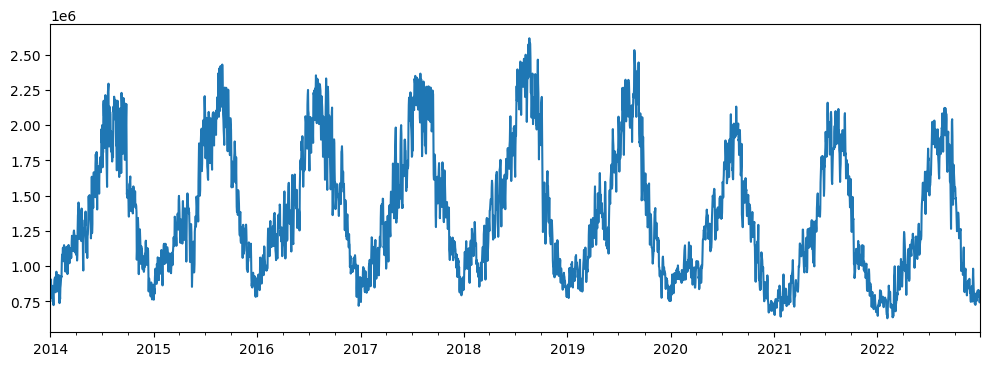

In [1918]:
plt.figure(figsize=(12,4))
energia['Energía total (kWh)'].plot()
plt.show()

Se puede ver a simple vista que la serie es muy densa, posiblemente a la gran cantidad de datos, por lo tanto vamos a realizar una reducción de granularidad a dia, semana y mes para analizar esta variable con más facilidad.

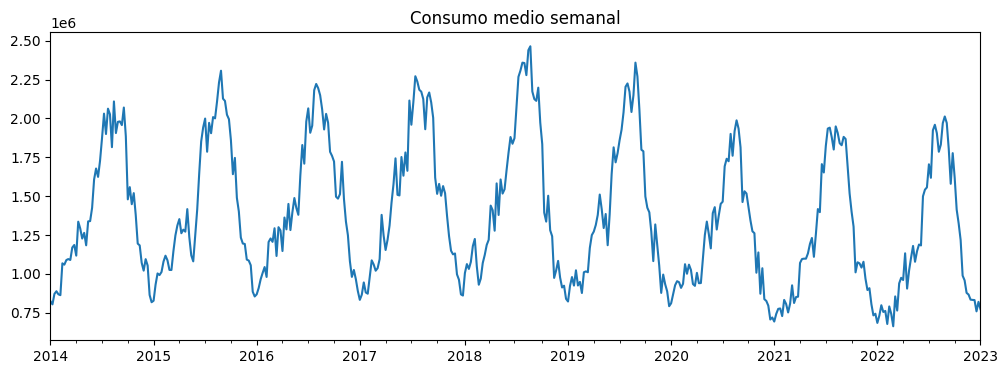

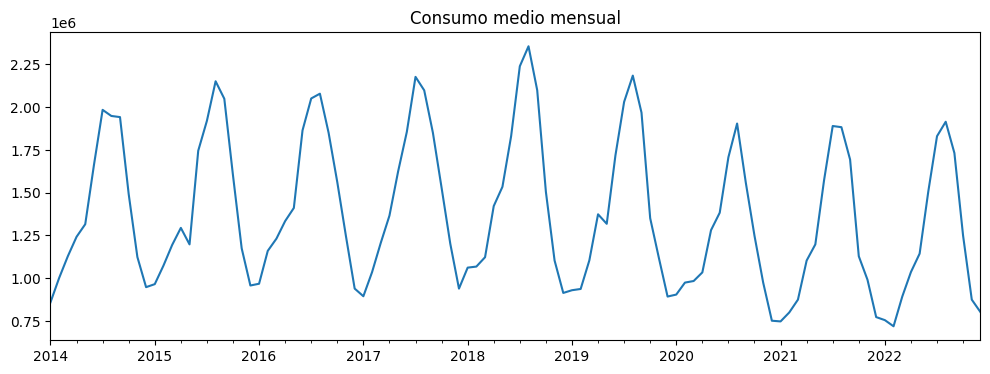

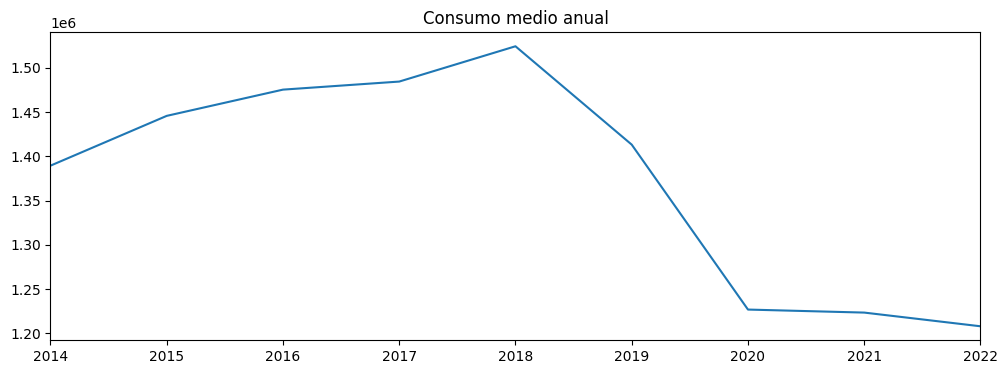

In [1919]:
energia_semanal = energia['Energía total (kWh)'].resample('W').mean()
energia_mensual = energia['Energía total (kWh)'].resample('ME').mean()
energia_anual = energia['Energía total (kWh)'].resample('YE').mean()

energia_semanal.plot(title='Consumo medio semanal', figsize=(12,4))
plt.show()

energia_mensual.plot(title='Consumo medio mensual', figsize=(12,4))
plt.show()

energia_anual.plot(title='Consumo medio anual', figsize=(12,4))
plt.show()

Aquí podemos ver como al principio parecía haber una tendencia ascendente, pero a partir de 2018 el consumo de Energía total (kWh) da un bajón entre 2019 y 2020, después empieza a disminuir de una forma mucho más lenta, pareciendo que se mantiene.

Ahora vamos a revisar si hay alguna posible estacionalidad.

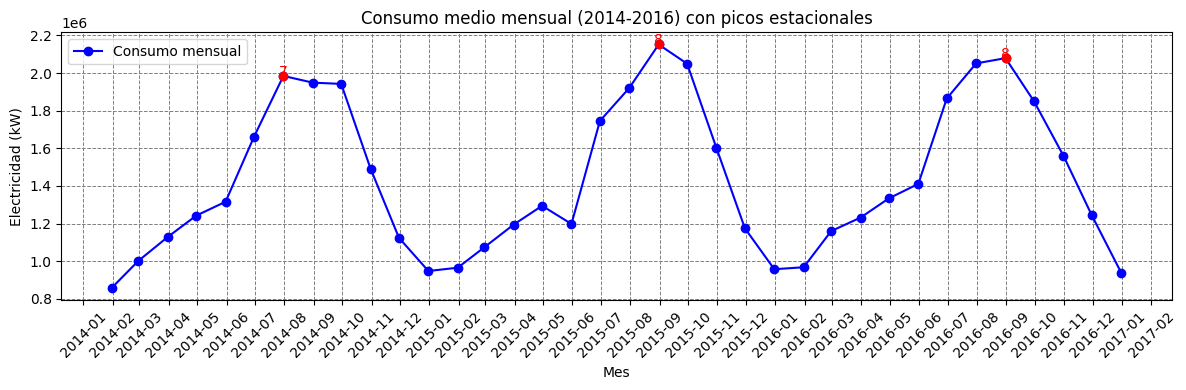

In [1920]:
# Selección de rango
ts = energia_mensual["2014":"2016"]

# Crear la figura
fig, ax = plt.subplots(figsize=(12,4))

# Graficar línea principal
ax.plot(ts.index, ts.values, marker='o', color='blue', label='Consumo mensual')

# Resaltar el pico de cada año
for year in ts.index.year.unique():
    pico = ts[ts.index.year == year].idxmax()
    ax.scatter(pico, ts[pico], color='red', zorder=5)
    ax.text(pico, ts[pico]+0.1, str(pico.month), ha='center', color='red')

# Título y etiquetas
ax.set_title("Consumo medio mensual (2014-2016) con picos estacionales")
ax.set_xlabel("Mes")
ax.set_ylabel("Electricidad (kW)")

# Grid
ax.grid(color='gray', linestyle='--', linewidth=0.7)

# Configurar eje X para mostrar todos los meses
ax.xaxis.set_major_locator(mdates.MonthLocator())  # cada mes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotar etiquetas para que no se superpongan
plt.xticks(rotation=45)

# Leyenda
ax.legend()

plt.tight_layout()
plt.show()


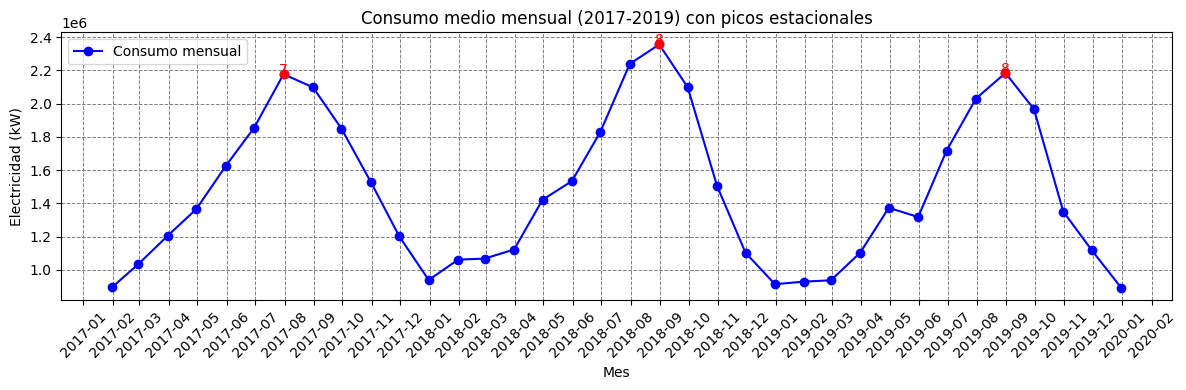

In [1921]:
# Selección de rango
ts = energia_mensual["2017":"2019"]

# Crear la figura
fig, ax = plt.subplots(figsize=(12,4))

# Graficar línea principal
ax.plot(ts.index, ts.values, marker='o', color='blue', label='Consumo mensual')

# Resaltar el pico de cada año
for year in ts.index.year.unique():
    pico = ts[ts.index.year == year].idxmax()
    ax.scatter(pico, ts[pico], color='red', zorder=5)
    ax.text(pico, ts[pico]+0.1, str(pico.month), ha='center', color='red')

# Título y etiquetas
ax.set_title("Consumo medio mensual (2017-2019) con picos estacionales")
ax.set_xlabel("Mes")
ax.set_ylabel("Electricidad (kW)")

# Grid
ax.grid(color='gray', linestyle='--', linewidth=0.7)

# Configurar eje X para mostrar todos los meses
ax.xaxis.set_major_locator(mdates.MonthLocator())  # cada mes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotar etiquetas para que no se superpongan
plt.xticks(rotation=45)

# Leyenda
ax.legend()

plt.tight_layout()
plt.show()


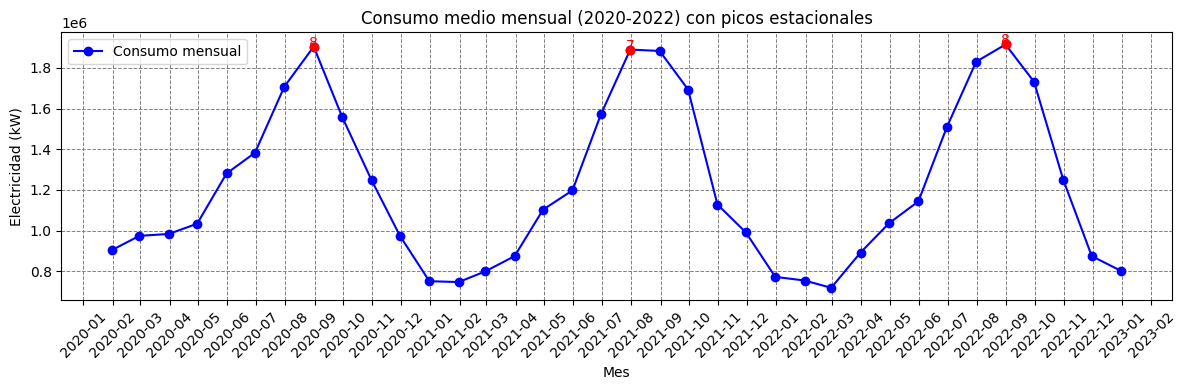

In [1922]:
# Selección de rango
ts = energia_mensual["2020":"2022"]

# Crear la figura
fig, ax = plt.subplots(figsize=(12,4))

# Graficar línea principal
ax.plot(ts.index, ts.values, marker='o', color='blue', label='Consumo mensual')

# Resaltar el pico de cada año
for year in ts.index.year.unique():
    pico = ts[ts.index.year == year].idxmax()
    ax.scatter(pico, ts[pico], color='red', zorder=5)
    ax.text(pico, ts[pico]+0.1, str(pico.month), ha='center', color='red')

# Título y etiquetas
ax.set_title("Consumo medio mensual (2020-2022) con picos estacionales")
ax.set_xlabel("Mes")
ax.set_ylabel("Electricidad (kW)")

# Grid
ax.grid(color='gray', linestyle='--', linewidth=0.7)

# Configurar eje X para mostrar todos los meses
ax.xaxis.set_major_locator(mdates.MonthLocator())  # cada mes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotar etiquetas para que no se superpongan
plt.xticks(rotation=45)

# Leyenda
ax.legend()

plt.tight_layout()
plt.show()


Se puede ver que existe una posible estacionalidad, puesto que que parece que sube a partir de junio y baja a partir de septiembre u octubre, bajando de manera consistente hasta enero, cada año.

Ahora vamos a analizar el histograma.

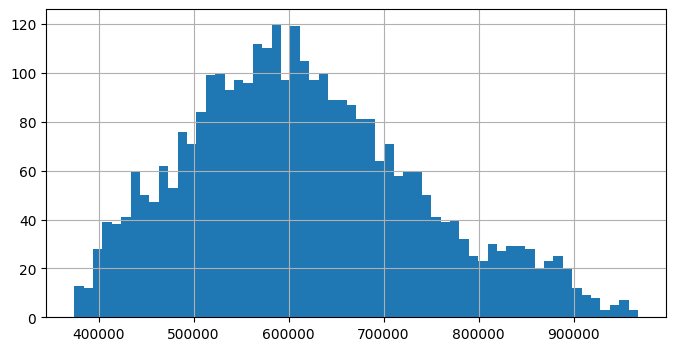

In [1923]:
energia['Electricidad (kW)'].hist(bins=60, figsize=(8,4))
plt.show()

Se puede ver como gran parte de los datos están situados entre los valores 450000 y 750000, haciendo que la mayor parte del consumo de electricidad esté entre la parte baja y mediana del histograma, haciendo haya una cola hacia la derecha y por lo tanto, un sesgo positivo, que implica que no es una distribución normal. Vemos también como la distribución de los datos parece ser bastante ancha.

Ahora vamos a analizar los componentes que tenemos cuando descompongamos la variable.

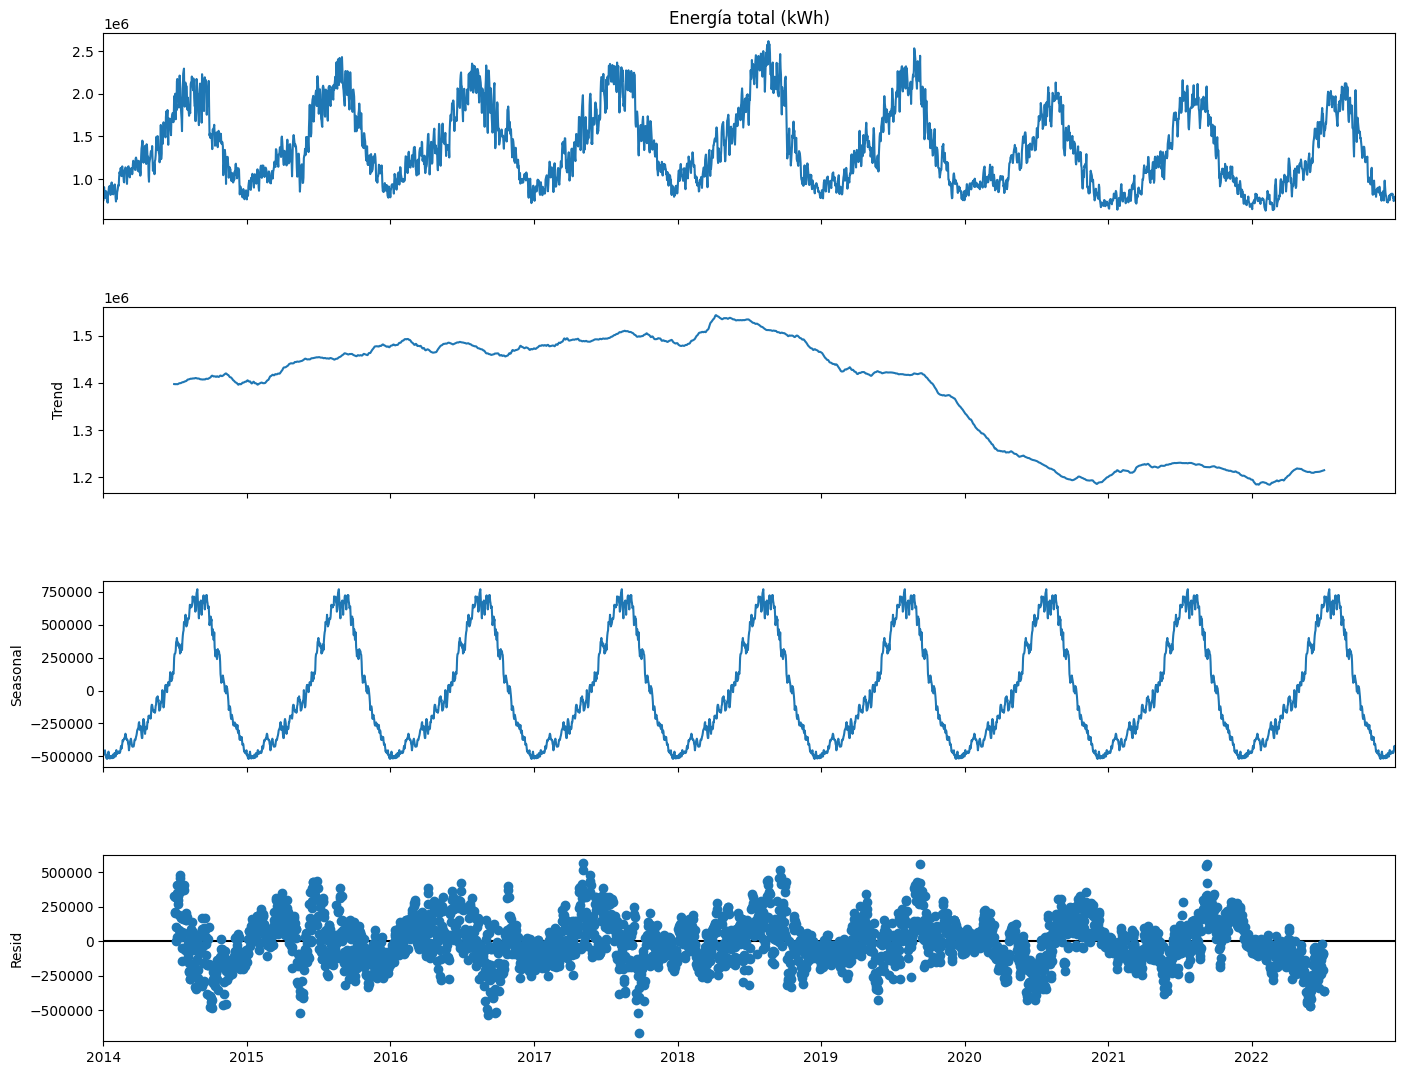

In [1924]:
resultado = seasonal_decompose(energia['Energía total (kWh)'], model='additive', period=30*12)
fig = resultado.plot()
fig.set_size_inches((16,12))
plt.show()

Primero revisaremos la tendencia, como habíamos hecho antes, donde habia un ascenso, luego un descentro, y luego otro descenso mucho más lento.

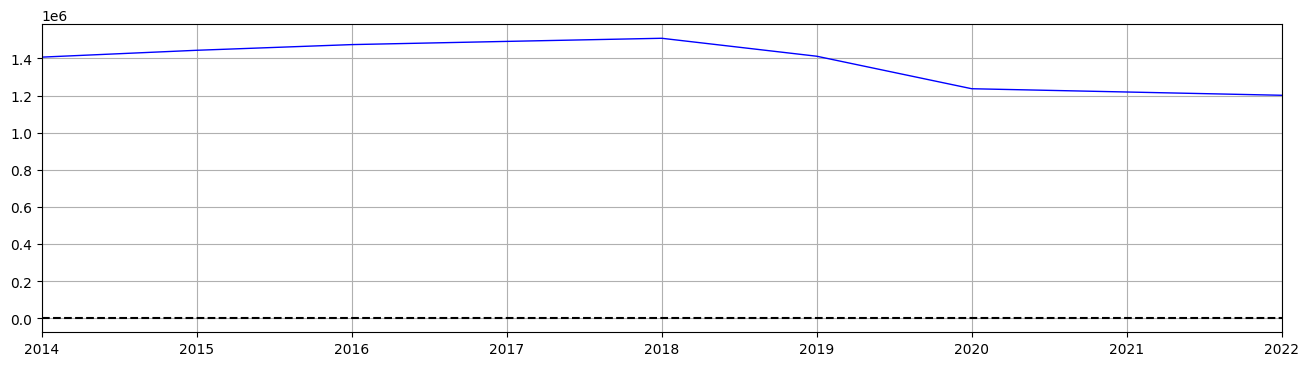

In [1925]:
# Reducir a 1 punto cada día para visualizar mejor
resultado_daily = resultado.trend.resample('YE').mean()

fig, ax = plt.subplots(figsize=(16,4))
resultado_daily.plot(ax=ax, color='blue', linewidth=1)
ax.axhline(0, color='black', linestyle='--')
ax.grid(True)
plt.show()

Al consultar la tendencia de manera anual, podemos ver que hasta 2018 parece haber un aumento, y que poco después empieza a bajar hasta 2020, luego empieza a disminuir mucho más lento, pareciendo que se está manteniendo, justo igual como antes.

Comprobaremos la estacionalidad.

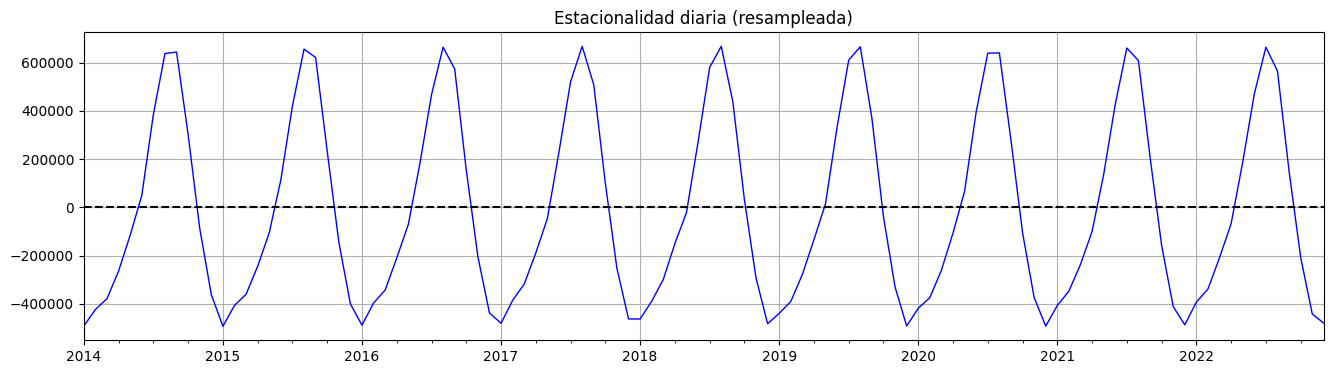

In [1926]:
# Reducir a 1 punto cada día para visualizar mejor
resultado_daily = resultado.seasonal.resample('ME').mean()

fig, ax = plt.subplots(figsize=(16,4))
resultado_daily.plot(ax=ax, color='blue', linewidth=1)
ax.axhline(0, color='black', linestyle='--')
ax.set_title('Estacionalidad diaria (resampleada)')
ax.grid(True)
plt.show()

Al analizarlo de forma anual, podemos ver que, efectivamente, hay una estacionalidad en esta variable, haciendo que esta variable pueda ser fácilmente predecible ya que sabemos que se irá repitiendo cada año.

In [1927]:
result = adfuller(energia['Energía total (kWh)'])
print('Estadístico ADF : %f' % result[0])
print('p-value: %f' % result[1])
print('Valores críticos:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

Estadístico ADF : -3.967523
p-value: 0.001590
Valores críticos:
	1%: -3.432
	5%: -2.862
	10%: -2.567


0.001590 < 0.05 Por lo que se rechaza la hipótesis nula, por lo tanto es estacionaria.

Ahora revisaremos la autocorrelación con lags=7 puesto que más adelante se nos pide un horizonte temporal de 7 días de la energía total consumida.

<Figure size 1000x600 with 0 Axes>

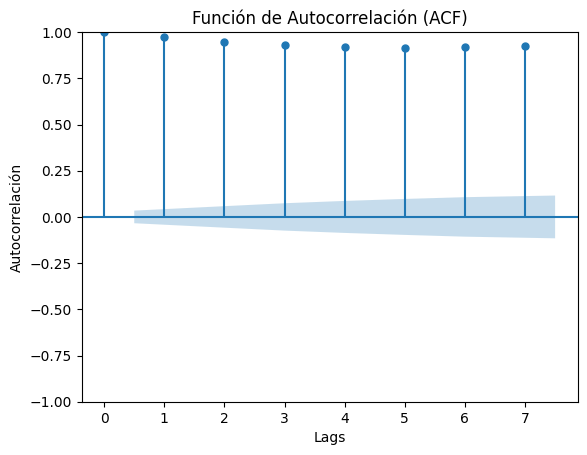

In [1928]:
plt.figure(figsize=(10, 6))
sm.graphics.tsa.plot_acf(energia['Energía total (kWh)'], lags=7)
plt.title('Función de Autocorrelación (ACF)')
plt.xlabel('Lags')
plt.ylabel('Autocorrelación')
plt.show()

Se puede ver que hay una autocorrelación muy alta en todos los puntos del lag, todos encima del 75%.

## Estacionalidad

### Electricidad (kW)

<Axes: title={'center': 'Consumo mensual promedio'}>

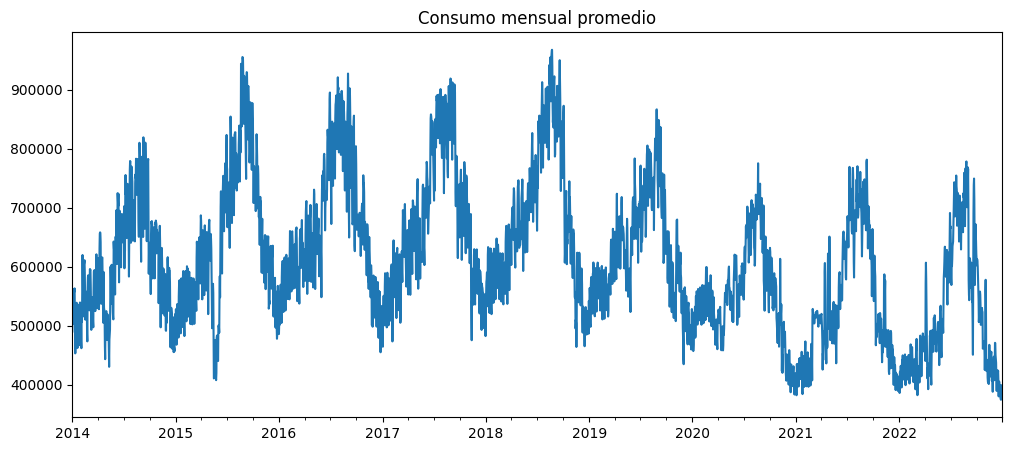

In [1929]:
energia_resample_mes = energia['Electricidad (kW)'].resample('D').mean()
energia_resample_mes.plot(title='Consumo mensual promedio', figsize=(12,5))

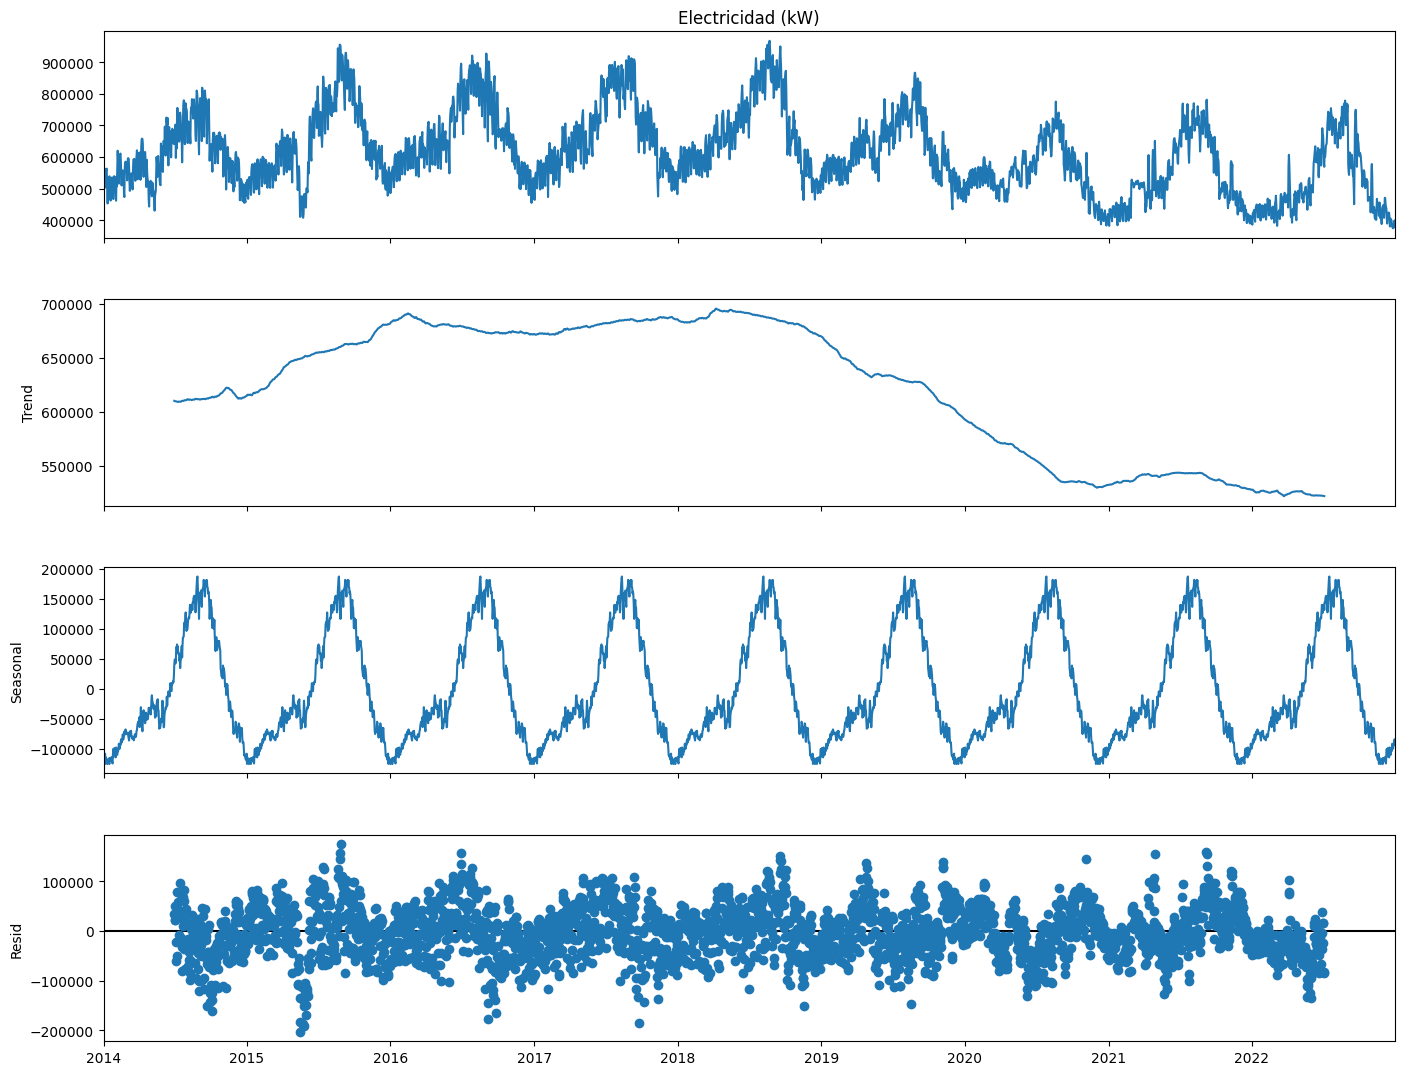

In [1930]:
energia = energia.asfreq('D')

resultado = seasonal_decompose(energia['Electricidad (kW)'], model='additive', period=30*12)
fig = resultado.plot()
fig.set_size_inches((16,12))
plt.show()

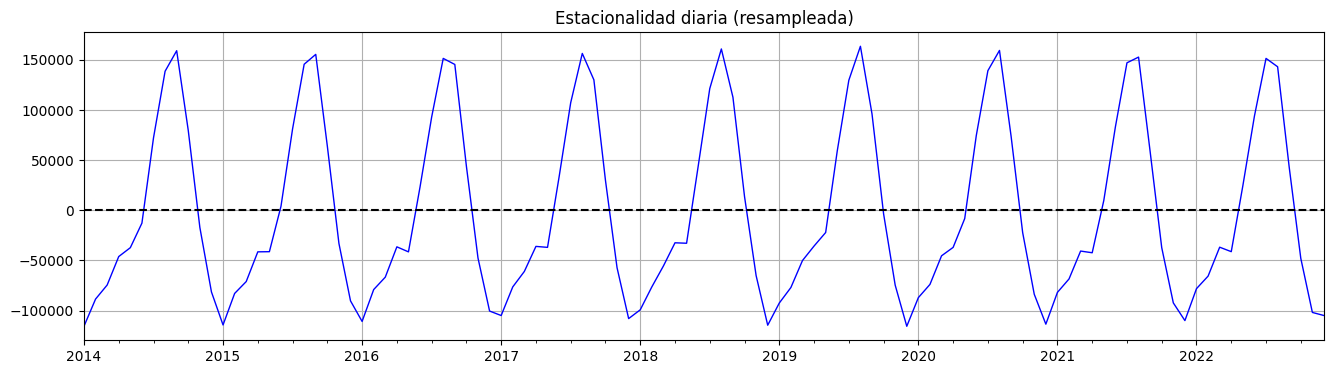

In [1931]:
# Reducir a 1 punto cada día para visualizar mejor
resultado_daily = resultado.seasonal.resample('ME').mean()

fig, ax = plt.subplots(figsize=(16,4))
resultado_daily.plot(ax=ax, color='blue', linewidth=1)
ax.axhline(0, color='black', linestyle='--')
ax.set_title('Estacionalidad diaria (resampleada)')
ax.grid(True)
plt.show()


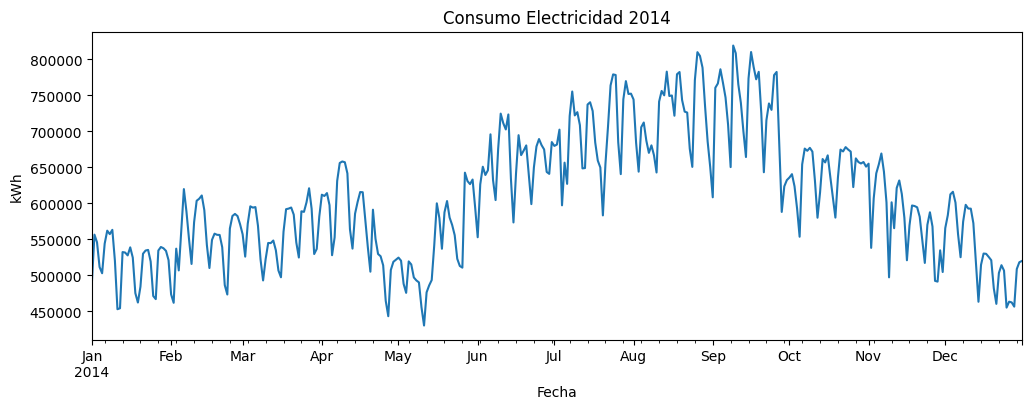

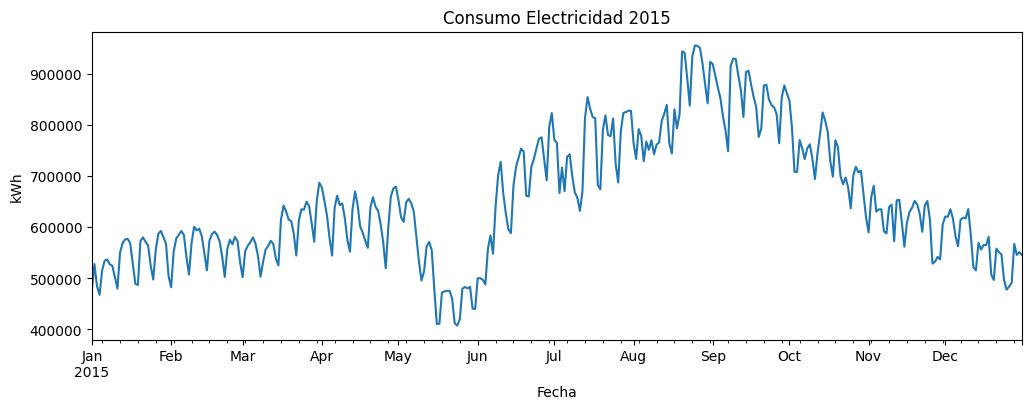

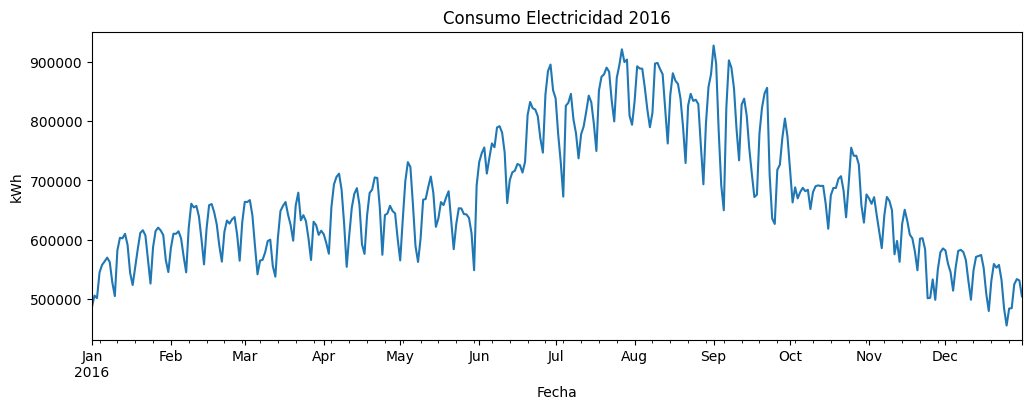

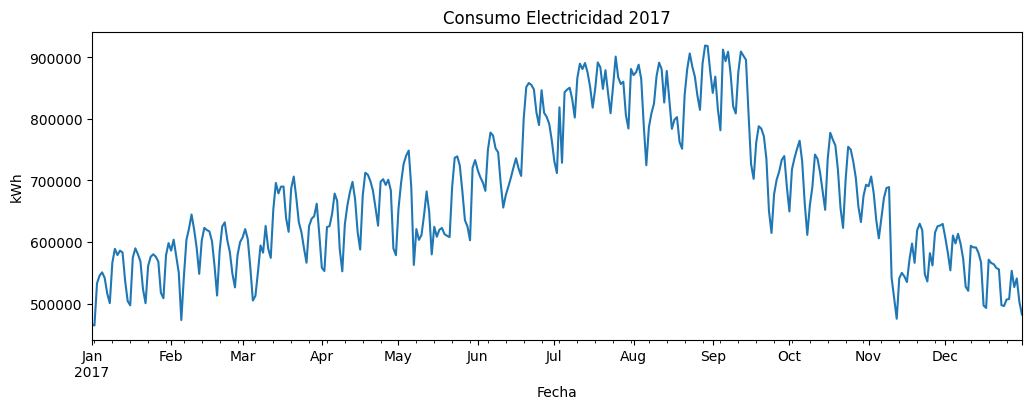

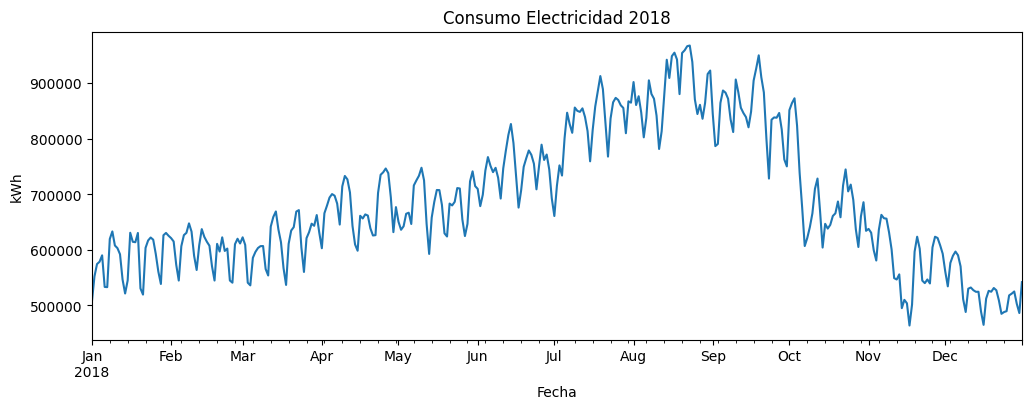

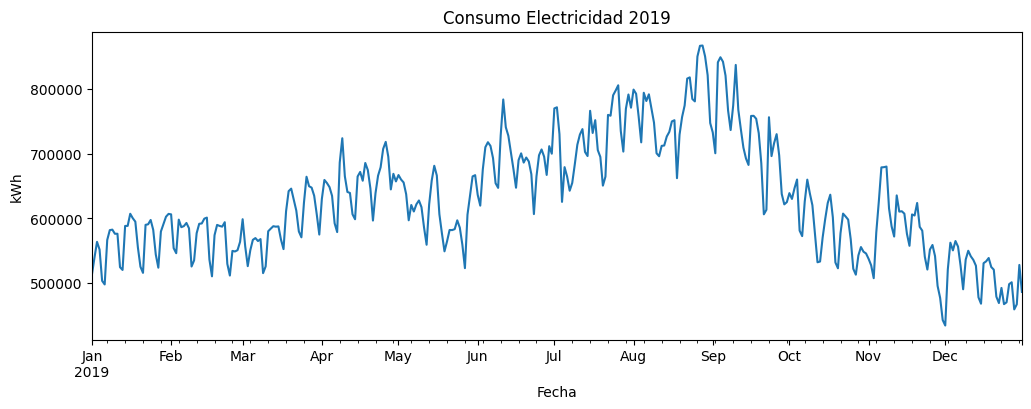

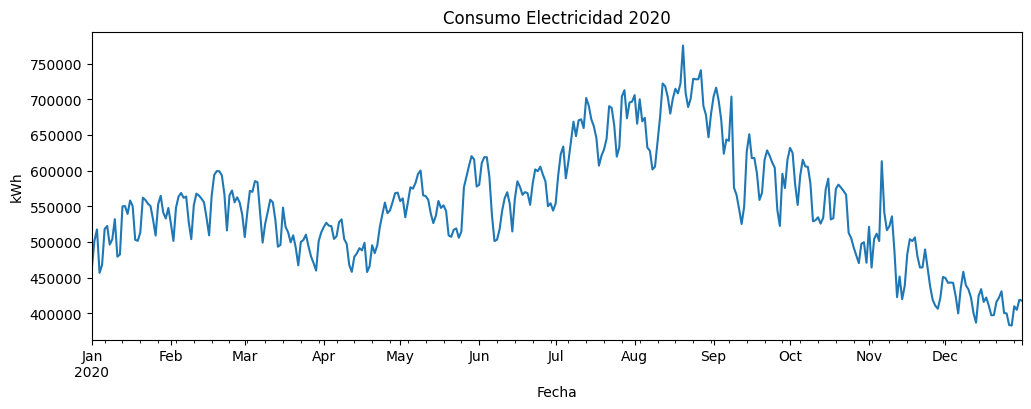

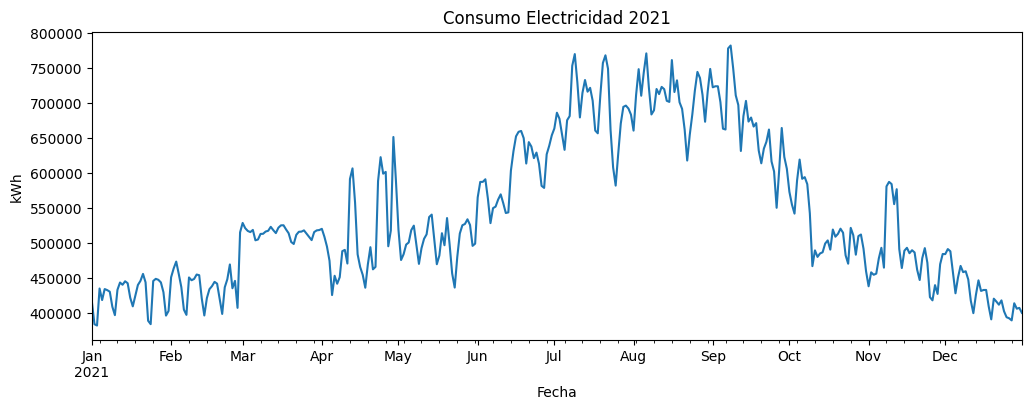

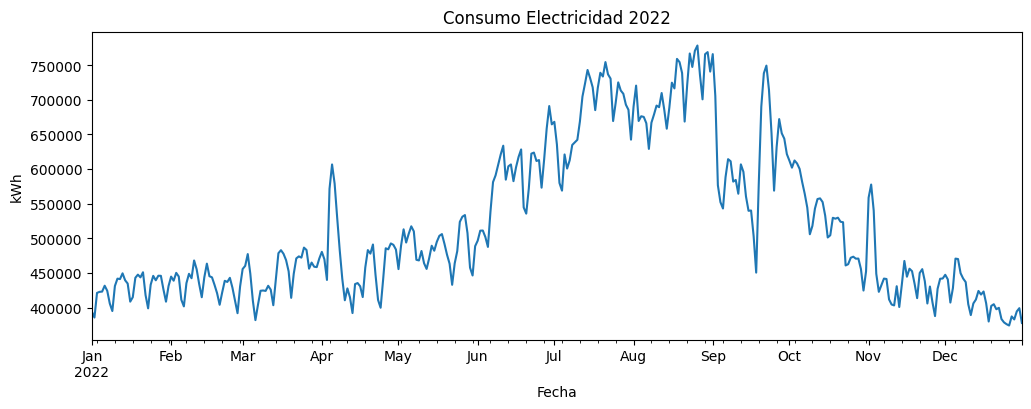

In [1932]:
import matplotlib.pyplot as plt

for year in range(2014, 2023):  # Ajusta según tu rango de datos
    plt.figure(figsize=(12,4))
    energia.loc[str(year), 'Electricidad (kW)'].plot(title=f'Consumo Electricidad {year}')
    plt.xlabel('Fecha')
    plt.ylabel('kWh')
    plt.show()


### Fotovoltaica (kW)

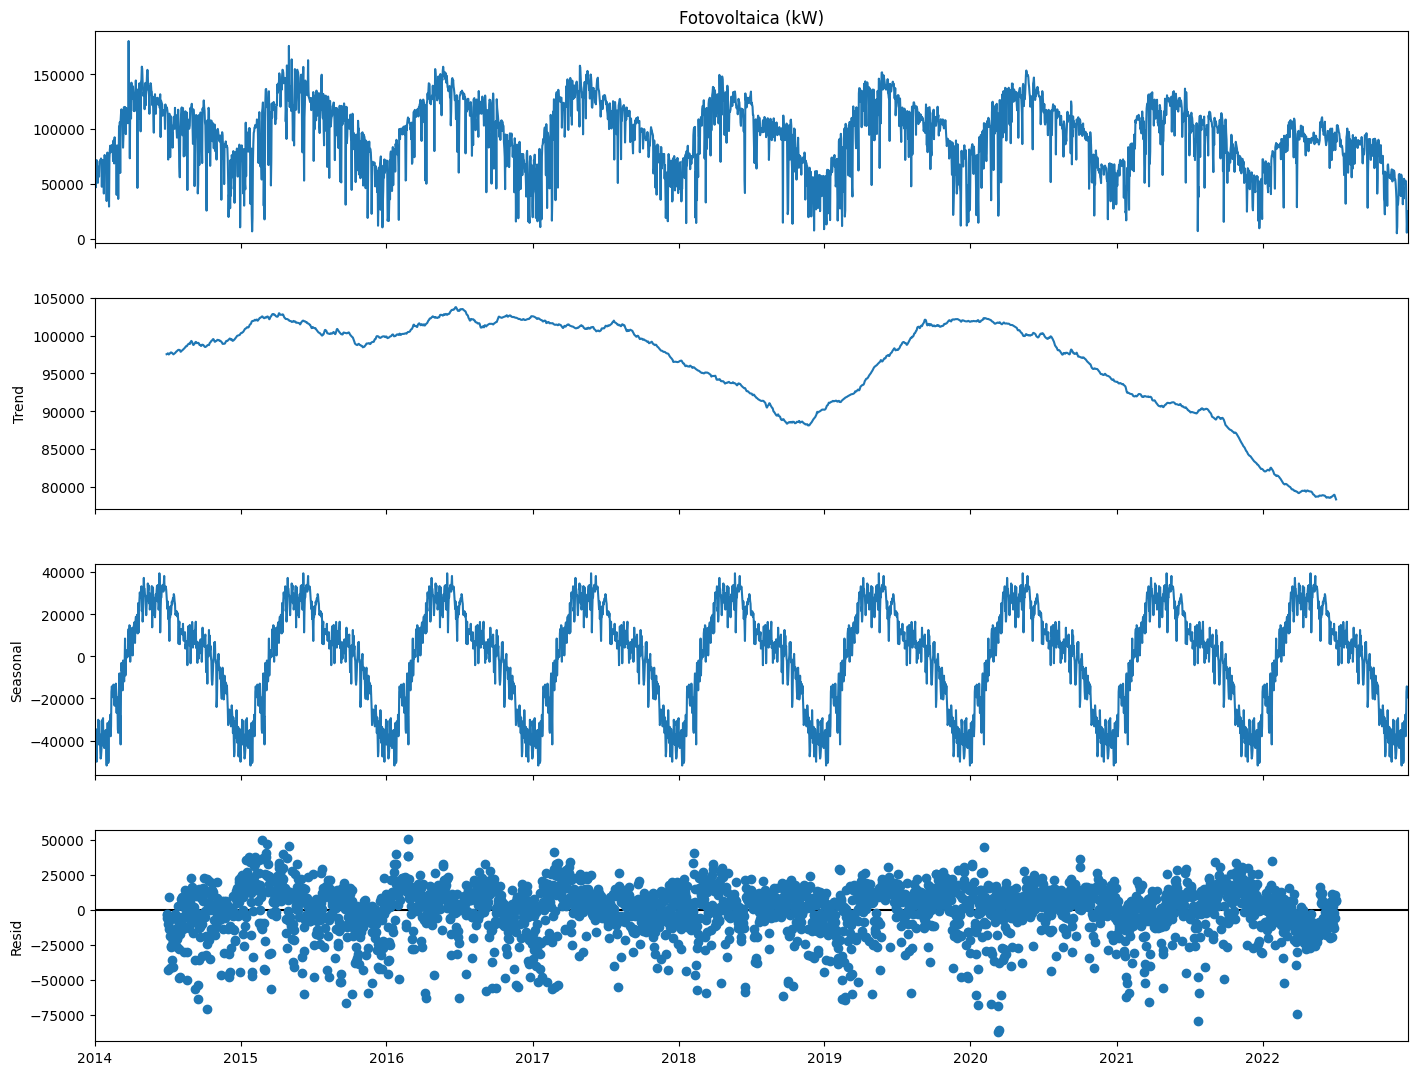

In [1933]:
from statsmodels.tsa.seasonal import seasonal_decompose
resultado = seasonal_decompose(energia['Fotovoltaica (kW)'], model='additive', period=30*12)
fig = resultado.plot()
fig.set_size_inches((16,12))
plt.show()

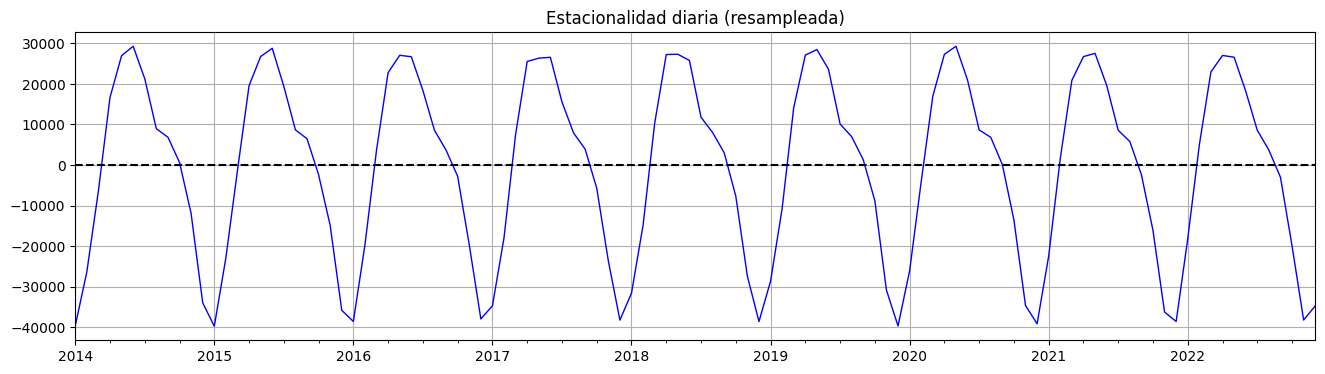

In [1934]:
# Reducir a 1 punto cada día para visualizar mejor
resultado_daily = resultado.seasonal.resample('ME').mean()

fig, ax = plt.subplots(figsize=(16,4))
resultado_daily.plot(ax=ax, color='blue', linewidth=1)
ax.axhline(0, color='black', linestyle='--')
ax.set_title('Estacionalidad diaria (resampleada)')
ax.grid(True)
plt.show()


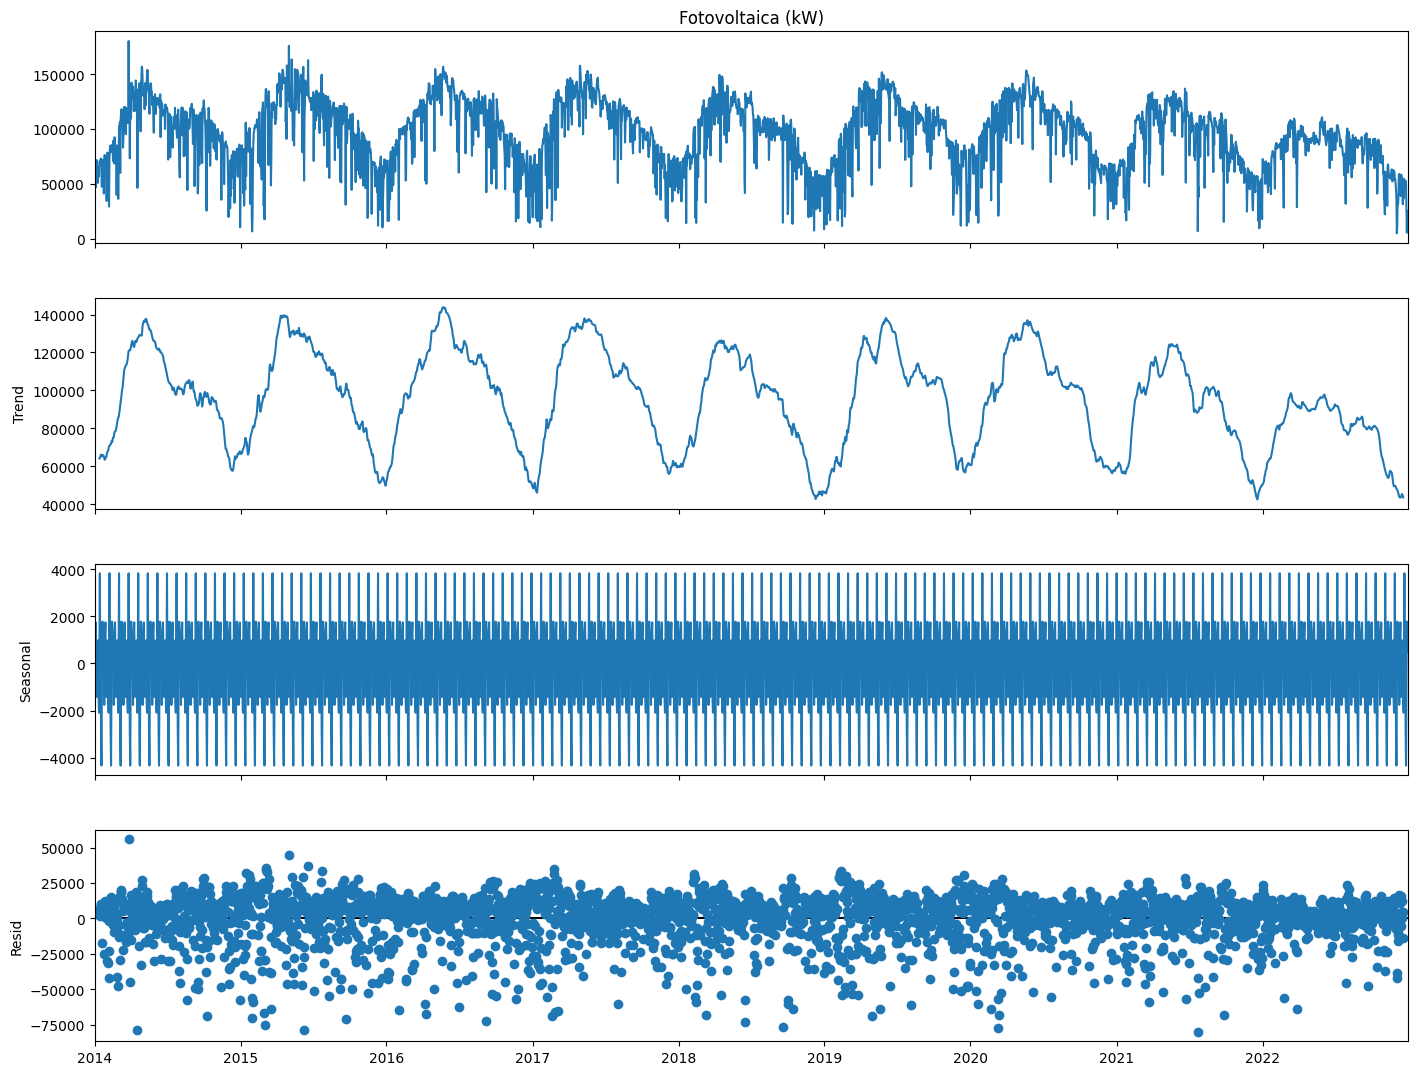

In [1935]:
from statsmodels.tsa.seasonal import seasonal_decompose
resultado = seasonal_decompose(energia['Fotovoltaica (kW)'], model='additive', period=24)
fig = resultado.plot()
fig.set_size_inches((16,12))
plt.show()

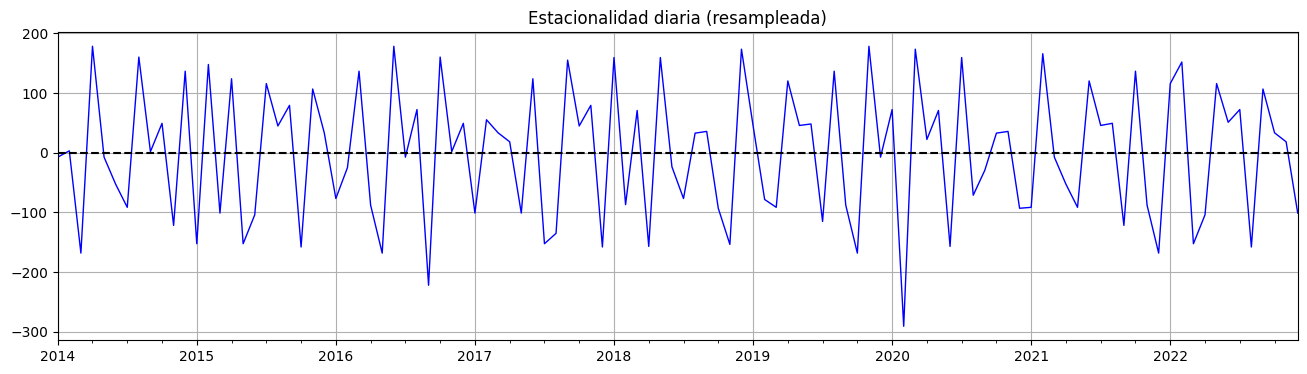

In [1936]:
# Reducir a 1 punto cada día para visualizar mejor
resultado_daily = resultado.seasonal.resample('ME').mean()

fig, ax = plt.subplots(figsize=(16,4))
resultado_daily.plot(ax=ax, color='blue', linewidth=1)
ax.axhline(0, color='black', linestyle='--')
ax.set_title('Estacionalidad diaria (resampleada)')
ax.grid(True)
plt.show()


### Refrigeración (kW)

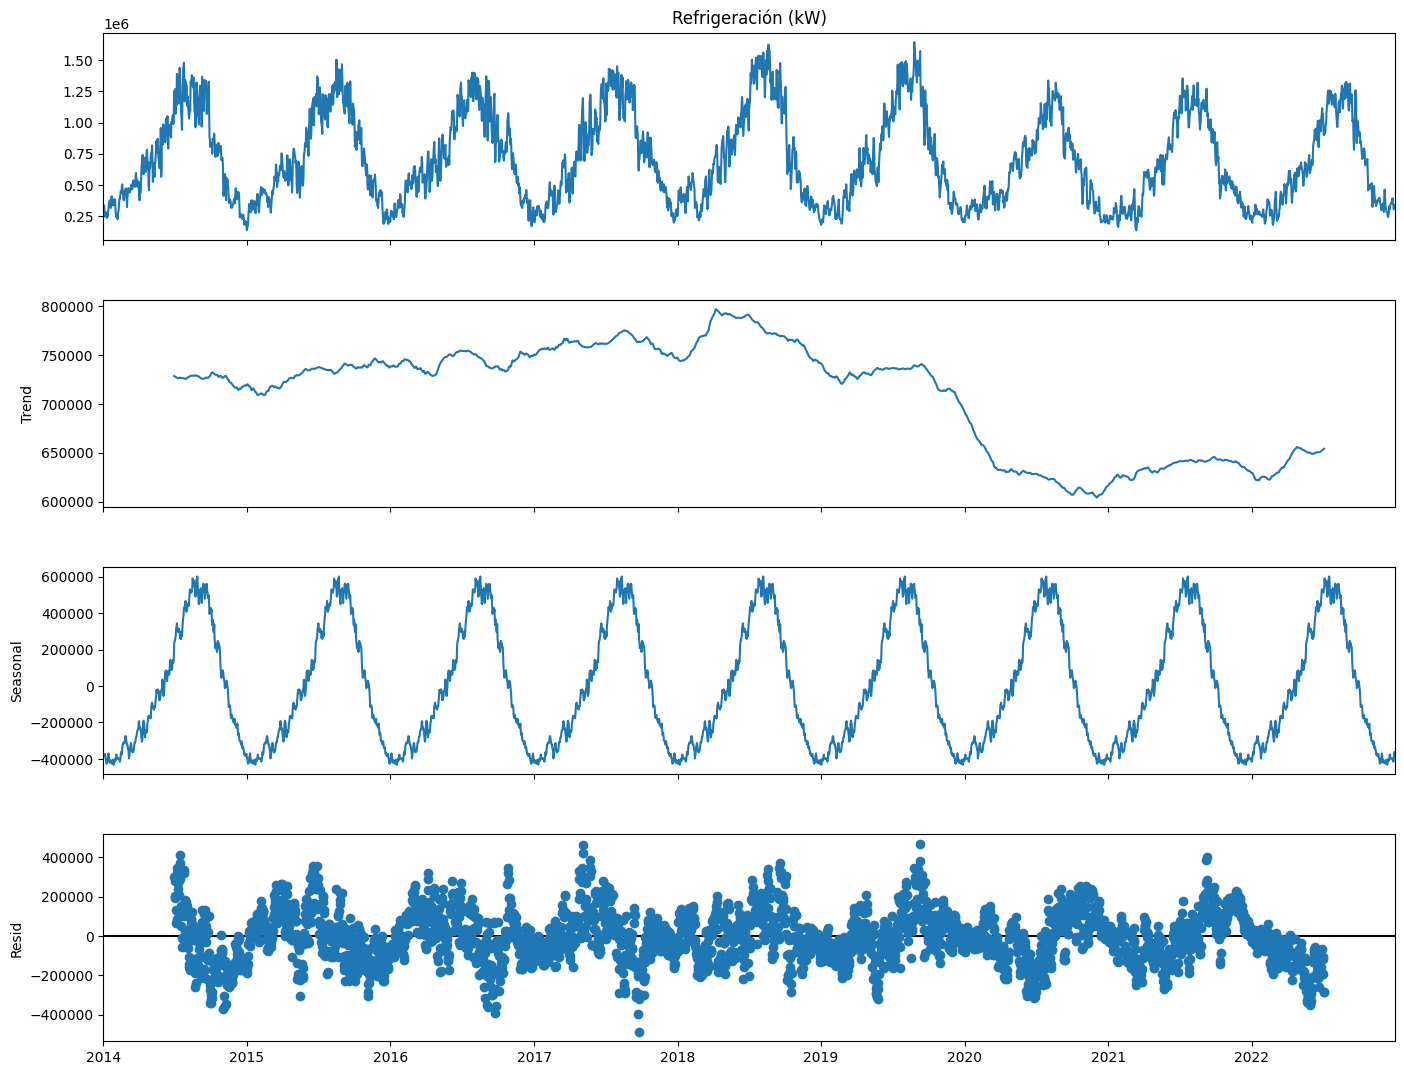

In [1937]:
from statsmodels.tsa.seasonal import seasonal_decompose
resultado = seasonal_decompose(energia['Refrigeración (kW)'], model='additive', period=30*12)
fig = resultado.plot()
fig.set_size_inches((16,12))
plt.show()

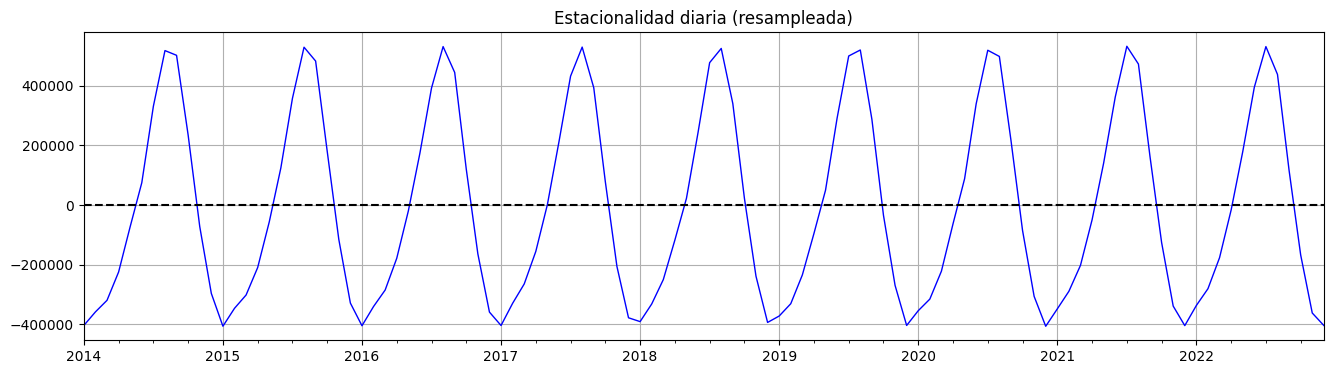

In [1938]:
# Reducir a 1 punto cada día para visualizar mejor
resultado_daily = resultado.seasonal.resample('ME').mean()

fig, ax = plt.subplots(figsize=(16,4))
resultado_daily.plot(ax=ax, color='blue', linewidth=1)
ax.axhline(0, color='black', linestyle='--')
ax.set_title('Estacionalidad diaria (resampleada)')
ax.grid(True)
plt.show()


### Calefacción (kWh)

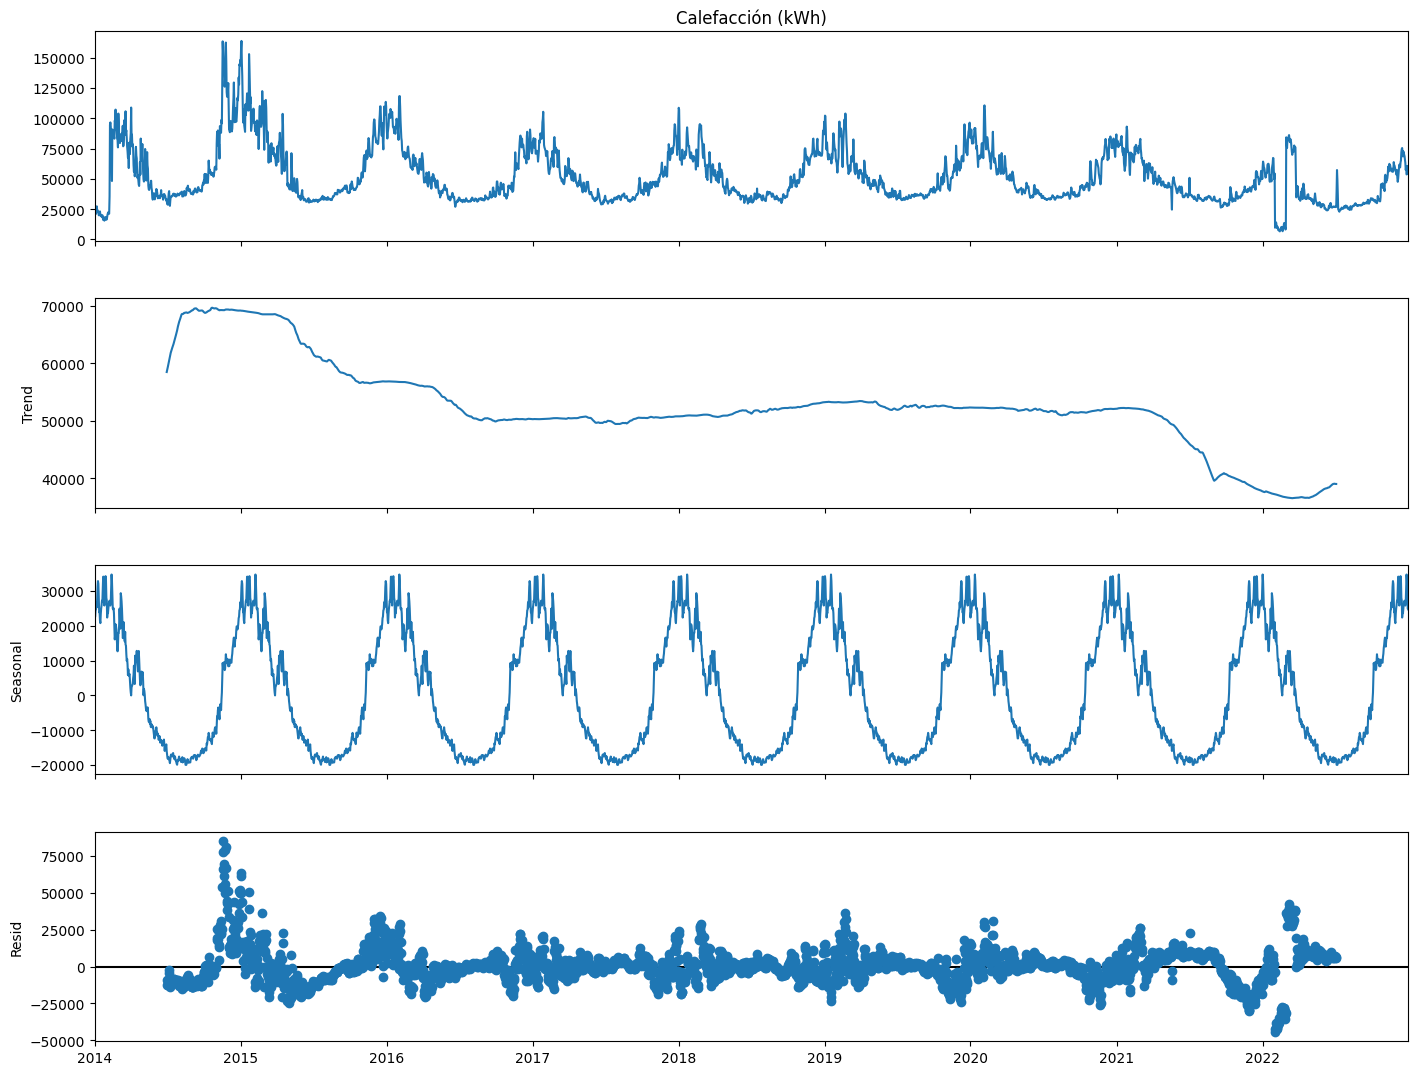

In [1939]:
from statsmodels.tsa.seasonal import seasonal_decompose
resultado = seasonal_decompose(energia['Calefacción (kWh)'], model='additive', period=30*12)
fig = resultado.plot()
fig.set_size_inches((16,12))
plt.show()

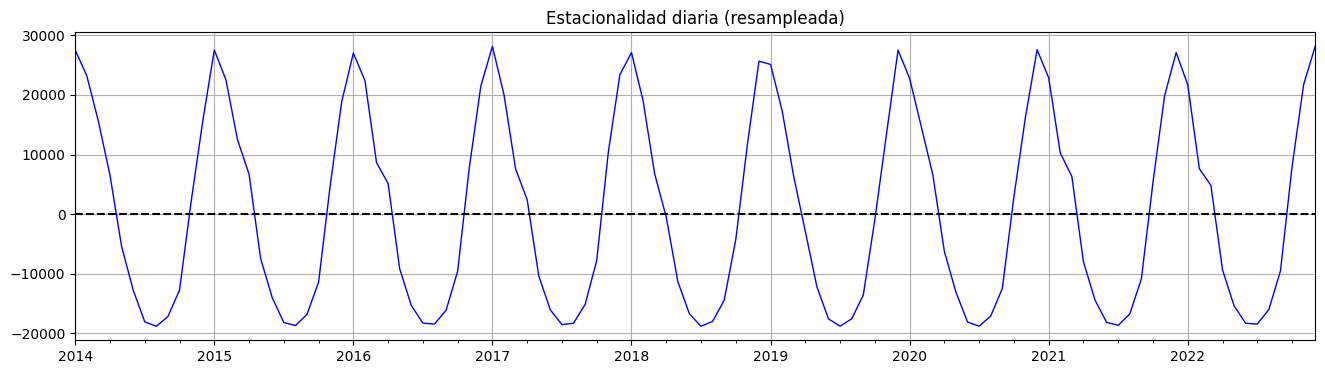

In [1940]:
# Reducir a 1 punto cada día para visualizar mejor
resultado_daily = resultado.seasonal.resample('ME').mean()

fig, ax = plt.subplots(figsize=(16,4))
resultado_daily.plot(ax=ax, color='blue', linewidth=1)
ax.axhline(0, color='black', linestyle='--')
ax.set_title('Estacionalidad diaria (resampleada)')
ax.grid(True)
plt.show()


### Energía total (kWh)

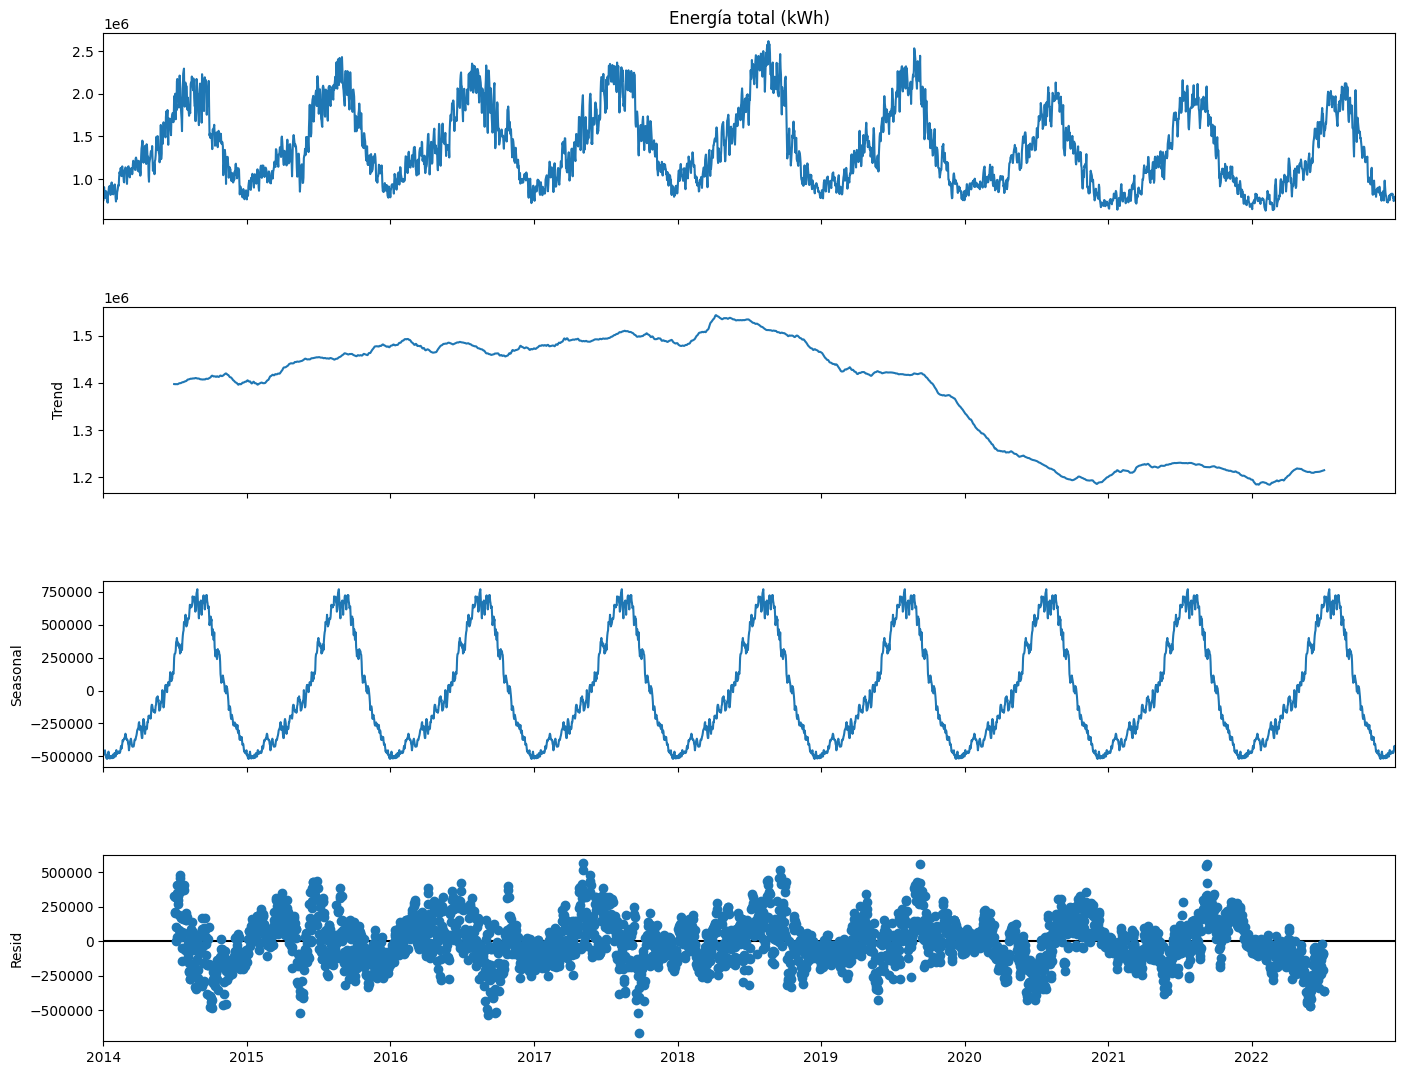

In [1941]:
resultado = seasonal_decompose(energia['Energía total (kWh)'], model='additive', period=30*12)
fig = resultado.plot()
fig.set_size_inches((16,12))
plt.show()

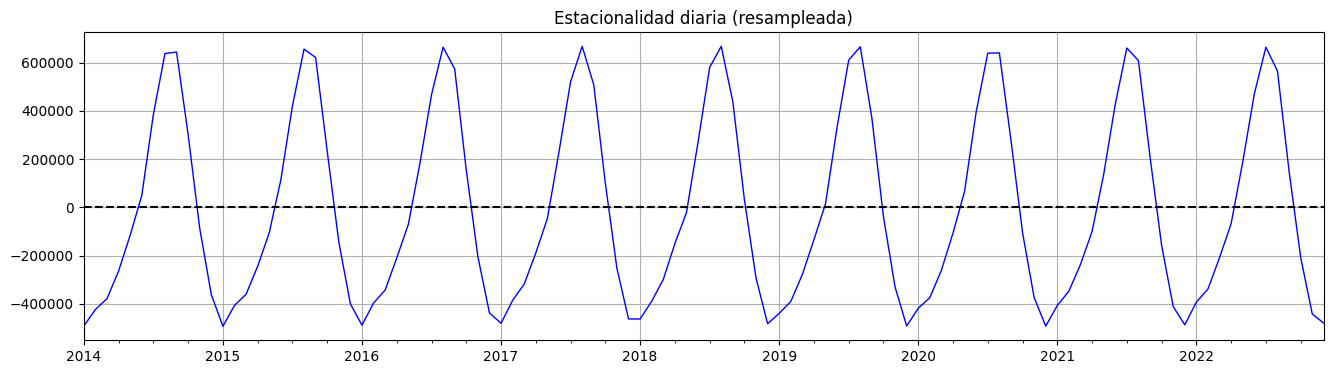

In [1942]:
# Reducir a 1 punto cada día para visualizar mejor
resultado_daily = resultado.seasonal.resample('ME').mean()

fig, ax = plt.subplots(figsize=(16,4))
resultado_daily.plot(ax=ax, color='blue', linewidth=1)
ax.axhline(0, color='black', linestyle='--')
ax.set_title('Estacionalidad diaria (resampleada)')
ax.grid(True)
plt.show()


### Emisión (kg CO₂)

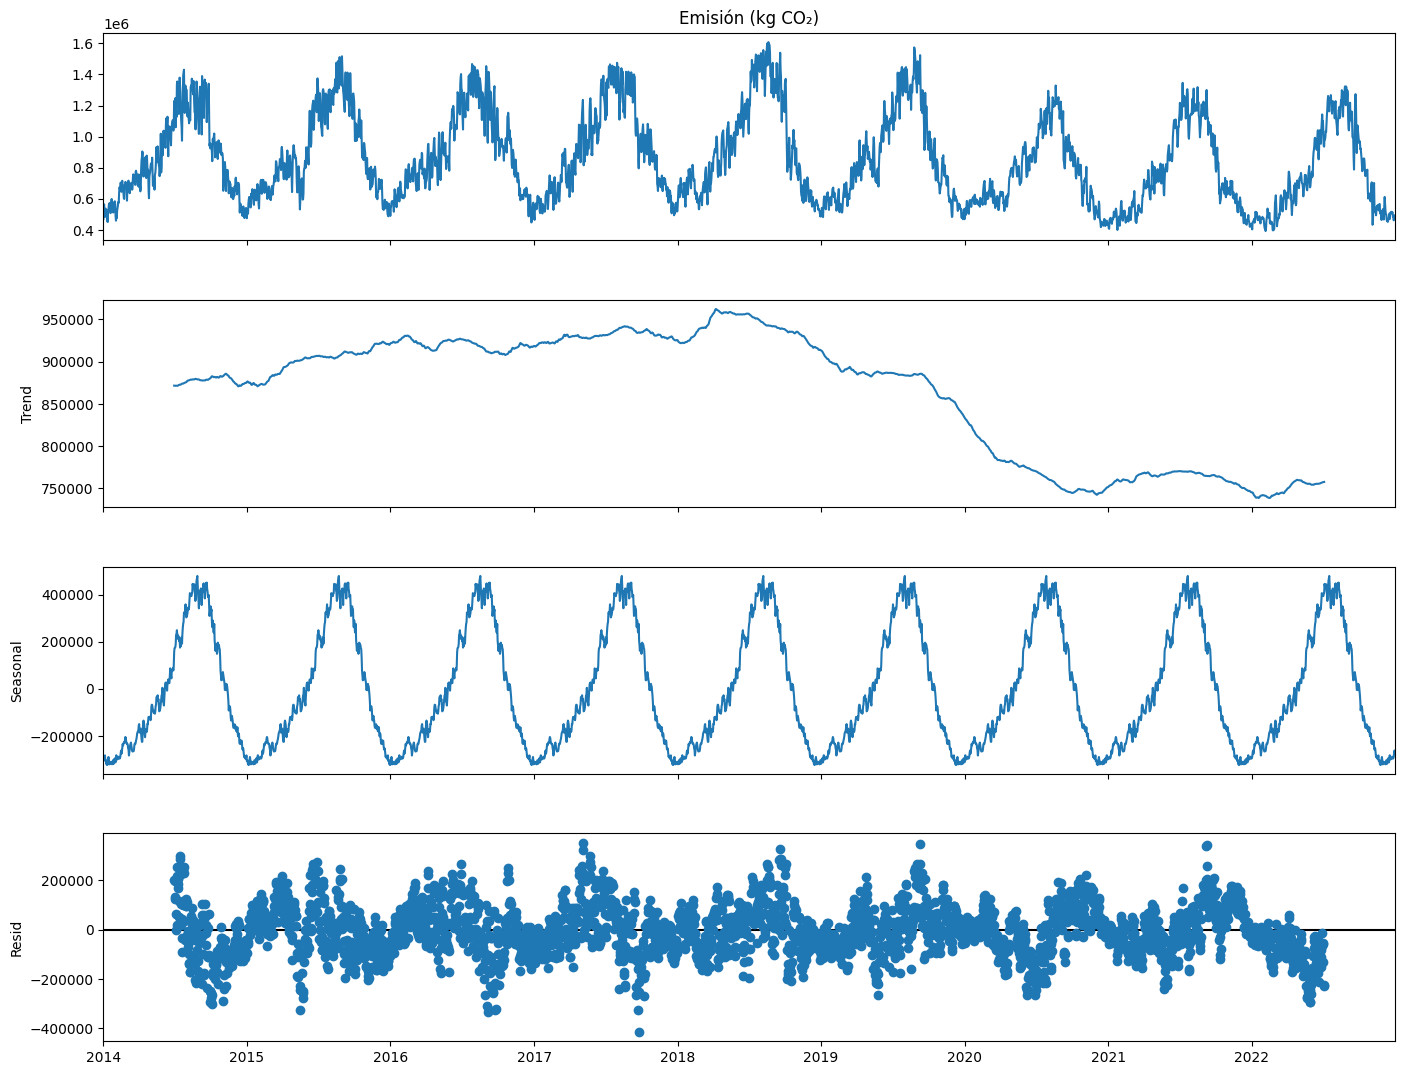

In [1943]:
from statsmodels.tsa.seasonal import seasonal_decompose
resultado = seasonal_decompose(energia['Emisión (kg CO₂)'], model='additive', period=30*12)
fig = resultado.plot()
fig.set_size_inches((16,12))
plt.show()

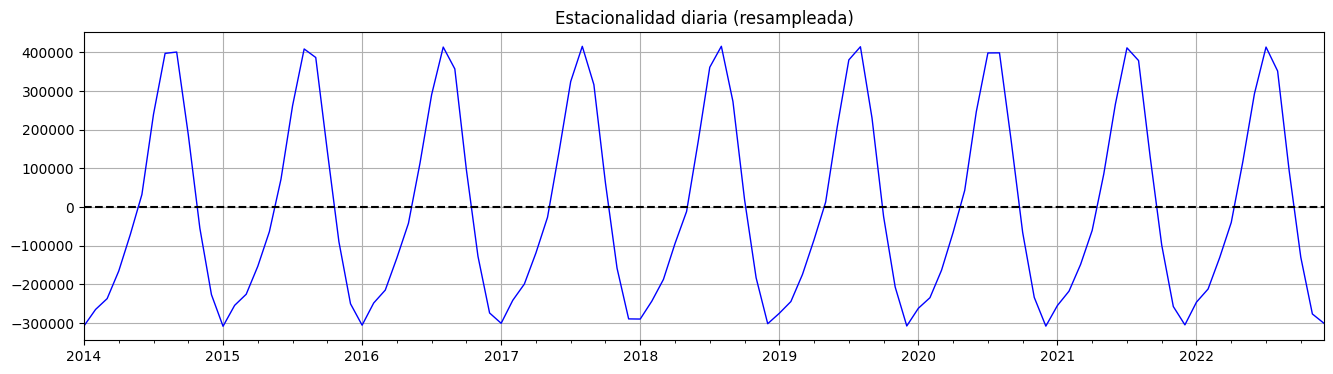

In [1944]:
# Reducir a 1 punto cada día para visualizar mejor
resultado_daily = resultado.seasonal.resample('ME').mean()

fig, ax = plt.subplots(figsize=(16,4))
resultado_daily.plot(ax=ax, color='blue', linewidth=1)
ax.axhline(0, color='black', linestyle='--')
ax.set_title('Estacionalidad diaria (resampleada)')
ax.grid(True)
plt.show()


## Tabla de correlación

In [1945]:
# Calcular varianza de todas las columnas numéricas
varianza = energia.var()

# Filtrar solo las que sean muy pequeñas (por ejemplo menor que 0.01)
bajas = varianza[varianza < 0.01]
columnas_bajas = varianza[varianza < 0.01].index
print(bajas)


Series([], dtype: float64)


In [1946]:
# Eliminamos los atributos originales
energia.drop(columnas_bajas, axis = 1, inplace = True)
# Mostramos como quedan los datos de nuevo
energia.head()

Día de la semana  Electricidad (kW)  Fotovoltaica (kW)  \
2014-01-01                 2          490049.28           62795.47   
2014-01-02                 3          556486.56           64284.00   
2014-01-03                 4          545831.45           67187.06   
2014-01-04                 5          511495.56           46798.28   
2014-01-05                 6          502806.80           70162.87   

            Refrigeración (kW)  Calefacción (kWh)  Energía total (kWh)  \
2014-01-01        243369.71770        20107.60131         753526.59901   
2014-01-02        323886.05169        23987.86135         904360.47304   
2014-01-03        337004.60237        22112.20695         904948.25932   
2014-01-04        252493.06189        21074.73561         785063.35750   
2014-01-05        249265.37031        22777.47812         774849.64843   

            Emisión (kg CO₂)  
2014-01-01          469960.0  
2014-01-02          564020.0  
2014-01-03          564390.0  
2014-01-04          489640.0  
2014-01-05          483270.0

In [1947]:
# Hacemos una matriz de correlación y visualizaremos sobre nuestra columna objetivo cuáles columnas parecen ser la más influyentes 
matriz_correlacion = energia.corr()
# Visualizaremos de mayor a menor
matriz_correlacion["Energía total (kWh)"].sort_values(ascending=False)

Energía total (kWh)    1.000000
Emisión (kg CO₂)       0.999645
Refrigeración (kW)     0.987160
Electricidad (kW)      0.920271
Fotovoltaica (kW)      0.400433
Día de la semana      -0.086557
Calefacción (kWh)     -0.596180
Name: Energía total (kWh), dtype: float64

In [1948]:
# Hacemos una matriz de correlación y visualizaremos sobre nuestra columna objetivo cuáles columnas parecen ser la más influyentes 
matriz_correlacion = energia.corr()
# Visualizaremos de mayor a menor
ordenadas = matriz_correlacion["Energía total (kWh)"].sort_values(ascending=False)
correlaciones_grandes = ordenadas[ordenadas >= 0.5]
correlaciones_pequeñas = ordenadas[(ordenadas >= -0.1) & (ordenadas <= 0.1)]

In [1949]:
print(correlaciones_grandes)

Energía total (kWh)    1.000000
Emisión (kg CO₂)       0.999645
Refrigeración (kW)     0.987160
Electricidad (kW)      0.920271
Name: Energía total (kWh), dtype: float64


In [1950]:
print(correlaciones_pequeñas)

Día de la semana   -0.086557
Name: Energía total (kWh), dtype: float64


In [1951]:
correlaciones_pequeñas_eliminar = ordenadas[(ordenadas >= -0.1) & (ordenadas <= 0.1)].index
correlaciones_pequeñas_eliminar = correlaciones_pequeñas_eliminar.drop("Día de la semana")

In [1952]:
# Eliminamos los atributos originales
energia.drop(correlaciones_pequeñas_eliminar, axis = 1, inplace = True)
# Mostramos como quedan los datos de nuevo
energia.head()

Día de la semana  Electricidad (kW)  Fotovoltaica (kW)  \
2014-01-01                 2          490049.28           62795.47   
2014-01-02                 3          556486.56           64284.00   
2014-01-03                 4          545831.45           67187.06   
2014-01-04                 5          511495.56           46798.28   
2014-01-05                 6          502806.80           70162.87   

            Refrigeración (kW)  Calefacción (kWh)  Energía total (kWh)  \
2014-01-01        243369.71770        20107.60131         753526.59901   
2014-01-02        323886.05169        23987.86135         904360.47304   
2014-01-03        337004.60237        22112.20695         904948.25932   
2014-01-04        252493.06189        21074.73561         785063.35750   
2014-01-05        249265.37031        22777.47812         774849.64843   

            Emisión (kg CO₂)  
2014-01-01          469960.0  
2014-01-02          564020.0  
2014-01-03          564390.0  
2014-01-04          489640.0  
2014-01-05          483270.0

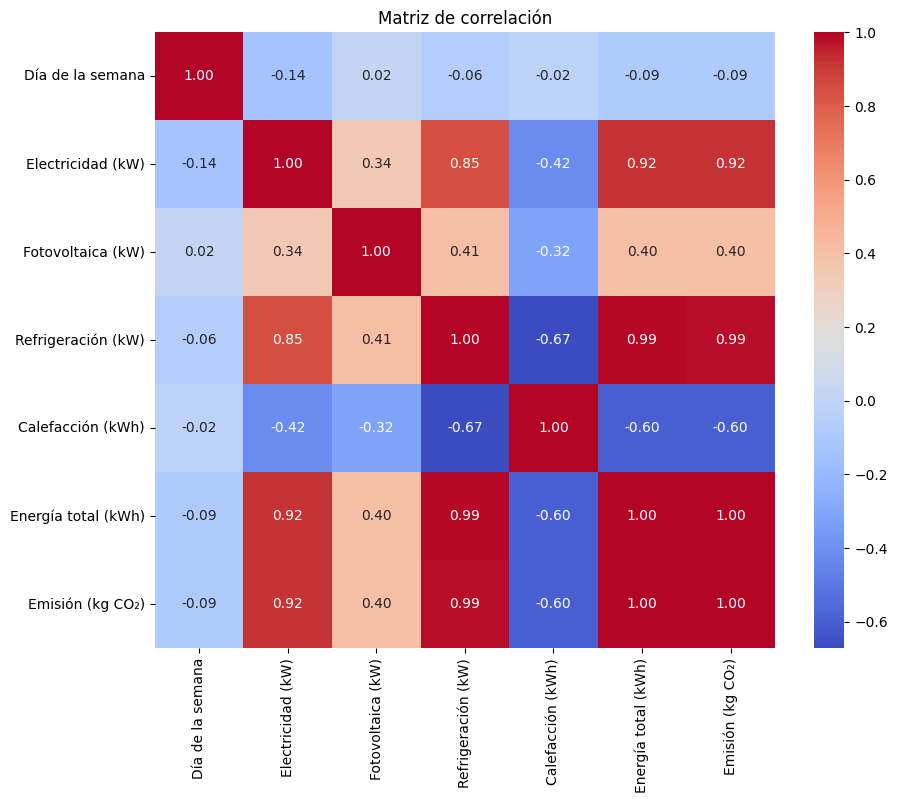

In [1953]:
# Crear la tabla de correlación
correlation_matrix = energia.corr()

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()

In [1954]:
# Comprobar frecuencia del índice
print(energia.index.freq)

# Asegurarnos de que todas las horas están presentes
energia = energia.asfreq("D")

# Detectar si faltan horas
faltantes = pd.date_range(start=energia.index.min(), end=energia.index.max(), freq='D').difference(energia.index)
print(f"Horas faltantes: {len(faltantes)}")


<Day>
Horas faltantes: 0


## Guardar dataset

In [1955]:
# energia.head()

In [1956]:
# energia.to_csv('Data/energia_preprocesada.csv')

# Datos_Climaticos

## Tratamiento de nulos

In [1957]:
# Visualizamos la cantidad de nulos que tiene el dataset
climaticos.isna().sum()

Día de la semana                0
Temperatura (°C)              187
Punto de rocío (°C)           187
Humedad (%)                   187
Dirección del viento          533
Velocidad del viento (m/s)    187
Ráfaga de viento (m/s)        187
Presión (hPa)                 187
Precipitación (mm)            187
Condición meteorológica       193
dtype: int64

Como se puede ver hay pocos nulos, por lo que podriamos eliminarlos o imputarlos, en nuestro caso, como no queremos eliminar ya que no queremos perder datos, decidimor imputar, para ello analizamos cómo funciona el dataset

In [1958]:
# Visualizamos las 5 primeras columnas del dataset
climaticos.head()

Día de la semana  Temperatura (°C)  Punto de rocío (°C)  \
2014-01-01 00:00:00                 2         11.666667           -17.777778   
2014-01-01 01:00:00                 2         10.555556             0.555556   
2014-01-01 02:00:00                 2         10.000000           -17.777778   
2014-01-01 03:00:00                 2          9.444444           -17.777778   
2014-01-01 04:00:00                 2          9.444444           -17.777778   

                     Humedad (%) Dirección del viento  \
2014-01-01 00:00:00         45.0                CALMA   
2014-01-01 01:00:00         50.0                    E   
2014-01-01 02:00:00         50.0                  ESE   
2014-01-01 03:00:00         52.0                  ESE   
2014-01-01 04:00:00         52.0                CALMA   

                     Velocidad del viento (m/s)  Ráfaga de viento (m/s)  \
2014-01-01 00:00:00                     0.00000                     0.0   
2014-01-01 01:00:00                     2.23520                     0.0   
2014-01-01 02:00:00                     1.34112                     0.0   
2014-01-01 03:00:00                     2.68224                     0.0   
2014-01-01 04:00:00                     0.00000                     0.0   

                     Presión (hPa)  Precipitación (mm) Condición meteorológica  
2014-01-01 00:00:00     977.312154                 0.0               Despejado  
2014-01-01 01:00:00     977.312154                 0.0               Despejado  
2014-01-01 02:00:00     977.312154                 0.0               Despejado  
2014-01-01 03:00:00     977.312154                 0.0               Despejado  
2014-01-01 04:00:00     977.650793                 0.0               Despejado

### imputación mediante interpolación temporal

En nuestro dataset, nuestros datos están organizados por horas, por lo que pensamos aprovecharnos sobre ello. Por lo tanto, "method = time" utiliza el DatetimeIndex para estimar los valores faltantes teniendo en cuenta la distancia real entre timestamps (en este caso, horas). Viendo la documentación, vemos cómo funciona en datos diarios o con mayor resolución, por lo que es adecuado para series horarias como esta. Además, al haber pocos valores nulos, la interpolación temporal proporciona una aproximación suave y coherente sin distorsionar el comportamiento general de la serie.

In [1959]:
# Seleccionamos todas las columnas numéricas del dataset
numericas = climaticos.select_dtypes(include='number').columns
# Utilizamos interpolación temporal en el dataset en las columnas seleccionadas
climaticos[numericas] = climaticos[numericas].interpolate(method='time')

Como este método solo se puede usar en columnas numéricas, seleccionamos esas columnas y realizamos la operación, dejandonos que sólo nos queden nulos en las dos variables de tipo object, en las cuales debemos utilizar un método diferente.

In [1960]:
# Visualizamos la cantidad de nulos que tiene el dataset
climaticos.isna().sum()

Día de la semana                0
Temperatura (°C)                0
Punto de rocío (°C)             0
Humedad (%)                     0
Dirección del viento          533
Velocidad del viento (m/s)      0
Ráfaga de viento (m/s)          0
Presión (hPa)                   0
Precipitación (mm)              0
Condición meteorológica       193
dtype: int64

### imputación mediante último y siguiente valor observado.

Para los nulos en las variables "object" hemos decidido en utilizar `ffill()` y `bfill()`, ya que como cogen el valor anterior o posterior respectivamente, pensamos en utilizarlos juntos por si al aplicar uno de ellos sigue habiendo nulos según como estén distribuidos en nuestro dataset. Además, la dirección del viento y la condición meteorológica no son variables tan volubles que cambien fácilmente cada hora, por lo que pensamos que son los métodos adecuados para estas dos variables.

In [1961]:
# Rellenamos las columnas con el valor anterior y posterior (ffill y bfill respectivamente)
climaticos['Dirección del viento'] = climaticos['Dirección del viento'].ffill().bfill()
climaticos['Condición meteorológica'] = climaticos['Condición meteorológica'].ffill().bfill()

Con esto podemos observar cómo hemos eliminado todos los nulos de nuestro dataset.

In [1962]:
# Visualizamos la cantidad de nulos que tiene el dataset
climaticos.isna().sum()

Día de la semana              0
Temperatura (°C)              0
Punto de rocío (°C)           0
Humedad (%)                   0
Dirección del viento          0
Velocidad del viento (m/s)    0
Ráfaga de viento (m/s)        0
Presión (hPa)                 0
Precipitación (mm)            0
Condición meteorológica       0
dtype: int64

## Outliers


Temperatura (ºC) la temperatura suele estar entre 0 y 40 y pocos, con bajadas de golpe hacia alrededor de -15. Existen outliers. 

Punto de rocío (ºC) va entre alrededor de -20 a 23, en algunos puntos la variable actúa de forma extraña, dando bajones en zona muy altas, por lo que indica que también hay presencia de outliers.

Humedad (%) a simple vista no parece que haya ningún valor por debajo de 0 o mayor a 100, por lo que no consideramos que hayan outliers.

Dirección del viento, al ser una clasificación, no se nota la presencia de outliers. 

Velocidad del viento (m/s) va de 0 a 15 con picos de hasta 22 (alrededor) en algunos puntos, aunque hay picos muy altos, por el contexto de la variable consideramos que no existen outliers. 

Rafaga de viento (m/s) va desde 0 hasta 20, con picos de 23 o alrededor. Se considera que no hay outliers viendo el contexto de la variable.

Presion fija en 1000, con 2 bajones a 0. Por lo tanto existen outliers.

Precipitacion aunque suele estar en 0, tiene picos muy altos hasta de alrededor de 20 o más, pero leyendo el contexto de la variable, no consideramos que existan outliers.

Condicion meteorologica, como sucedia en direccion del viento al ser una variable de clasificación no contiene outliers.

### Temperatura (°C)

Vamos a analizar la variable.

In [1963]:
# Visualizamos minimo, maximo, media, desviación típica, 25%, 50%, 75% y el número de valores que tiene la variable
print(climaticos['Temperatura (°C)'].describe())

count    78888.000000
mean        24.785825
std          9.512069
min        -17.777778
25%         17.222222
50%         25.000000
75%         32.222222
max         48.333333
Name: Temperatura (°C), dtype: float64


Aquí parece ser normal, puesto que hayan temperaturas entre -18ºC y 49ºC podrían ser normales. Por lo tanto, para esta variable, analizaremos los outliers desde su gráfica.

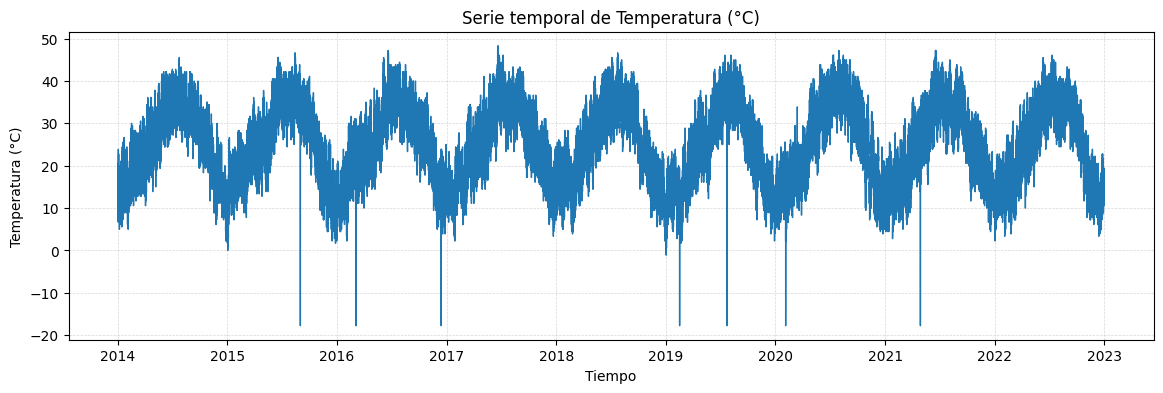

In [1964]:
# Creamos la gráfica de anchura 14, altura 4
fig, ax = plt.subplots(figsize=(14, 4))
# Pasamos las columnas que queremos representar
ax.plot(climaticos.index, climaticos['Temperatura (°C)'], linewidth=1)
# Nombre de la columna en el eje y
ax.set_ylabel('Temperatura (°C)')
# Nombre de la columna en el eje x
ax.set_xlabel('Tiempo')
# Nombre de la grafica
ax.set_title('Serie temporal de Temperatura (°C)')
# Grid de la gráfica
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
# Imprime la gráfica
plt.show()


Aquí se destacan bastante los outliers, puesto que la forma de la gráfica no suele bajar demasiado de 0 o incluso parece que -1ºC, por lo tanto solo detectaremos los valores que tengan menos de -10ºC, puesto que son picos muy notorios hacia abajo, por lo tanto esta temperatura no tiene sentido en la zona donde analiza el dataset del problema.

In [1965]:
# Elimina todos los valores por debajo de -10ºC
climaticos['Temperatura (°C)'] = climaticos['Temperatura (°C)'].where((climaticos['Temperatura (°C)'] >= -10)
)

Comprobamos cuántos outliers hemos eliminado.

In [1966]:
# Visualizamos la cantidad de nulos que tiene el dataset
climaticos.isna().sum()

Día de la semana               0
Temperatura (°C)              15
Punto de rocío (°C)            0
Humedad (%)                    0
Dirección del viento           0
Velocidad del viento (m/s)     0
Ráfaga de viento (m/s)         0
Presión (hPa)                  0
Precipitación (mm)             0
Condición meteorológica        0
dtype: int64

Vemos cómo hemos eliminado 15 outliers, vamos a imputar con intepolación temporal

In [1967]:
# Utilizamos interpolación temporal en el dataset en las columnas seleccionadas
climaticos['Temperatura (°C)'] = climaticos['Temperatura (°C)'].interpolate(method='time')

Vemos cómo queda el dataset.

In [1968]:
# Visualizamos minimo, maximo, media, desviación típica, 25%, 50%, 75% y el número de valores que tiene la variable
climaticos['Temperatura (°C)'].describe()

count    78888.000000
mean        24.793688
std          9.494418
min         -1.111111
25%         17.222222
50%         25.000000
75%         32.222222
max         48.333333
Name: Temperatura (°C), dtype: float64

Hemos imputados todos los nulos y sus valores parecen haber quedado bien. Vamos a revisar de nuevo la gráfica de su serie temporal.

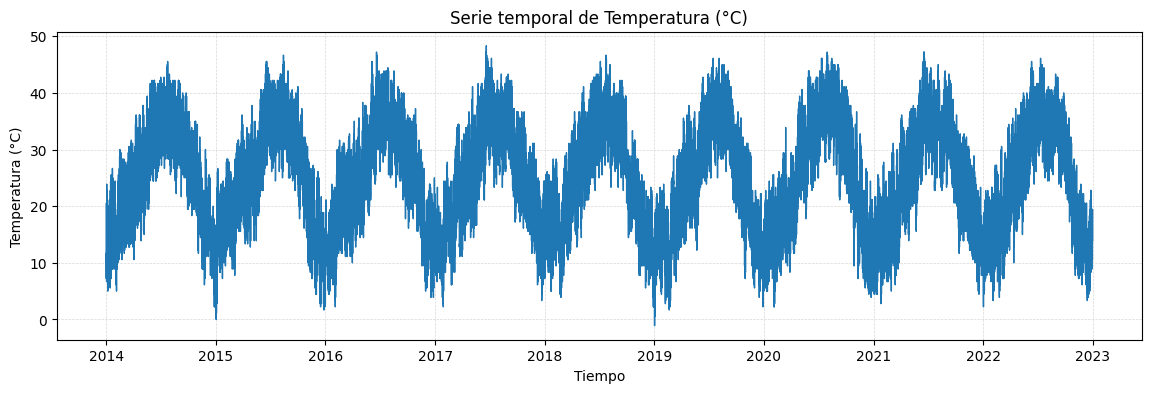

In [1969]:
# Creamos la gráfica de anchura 14, altura 4
fig, ax = plt.subplots(figsize=(14, 4))
# Pasamos las columnas que queremos representar
ax.plot(climaticos.index, climaticos['Temperatura (°C)'], linewidth=1)
# Nombre de la columna en el eje y
ax.set_ylabel('Temperatura (°C)')
# Nombre de la columna en el eje x
ax.set_xlabel('Tiempo')
# Nombre de la grafica
ax.set_title('Serie temporal de Temperatura (°C)')
# Grid de la gráfica
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
# Imprime la gráfica
plt.show()


Vemos cómo efectivamente, ya no hay valores que resalten hacia abajo, por lo que hemos tratado con los outliers de forma adecuada.

### Punto de rocío (°C)

Vamos a analizar esta variable.

In [1970]:
# Visualizamos minimo, maximo, media, desviación típica, 25%, 50%, 75% y el número de valores que tiene la variable
print(climaticos['Punto de rocío (°C)'].describe())

count    78888.000000
mean         3.794071
std          8.246256
min        -22.777778
25%         -2.222222
50%          2.777778
75%         10.000000
max         24.444444
Name: Punto de rocío (°C), dtype: float64


Vemos, al igual que paso con la anterior variable, los valores de esta variable parecen normales, vamos a analizar la gráfica.

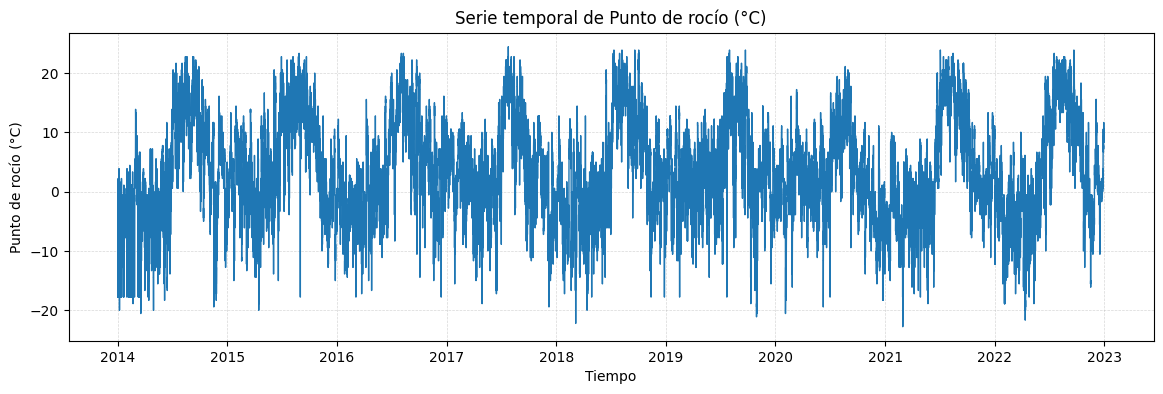

In [1971]:
# Creamos la gráfica de anchura 14, altura 4
fig, ax = plt.subplots(figsize=(14, 4))
# Pasamos las columnas que queremos representar
ax.plot(climaticos.index, climaticos['Punto de rocío (°C)'], linewidth=1)
# Nombre de la columna en el eje y
ax.set_ylabel('Punto de rocío (°C)')
# Nombre de la columna en el eje x
ax.set_xlabel('Tiempo')
# Nombre de la grafica
ax.set_title('Serie temporal de Punto de rocío (°C)')
# Grid de la gráfica
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
# Imprime la gráfica
plt.show()


Vemos que aunque haya algun bajon, parece que es el funcionamiento típico de la variable, por lo tanto lo identificamos como que esta variable no contiene outliers.

### Humedad (%)

Vamos a analizar esta variable.

In [1972]:
# Visualizamos minimo, maximo, media, desviación típica, 25%, 50%, 75% y el número de valores que tiene la variable
print(climaticos['Humedad (%)'].describe())

count    78888.000000
mean        31.297536
std         19.549718
min          0.000000
25%         17.000000
50%         27.000000
75%         41.000000
max        100.000000
Name: Humedad (%), dtype: float64


Vemos que los valores de humedad de forma porcentual son lógicos, por lo que vamos a visualizar la gráfica de su serie temporal.

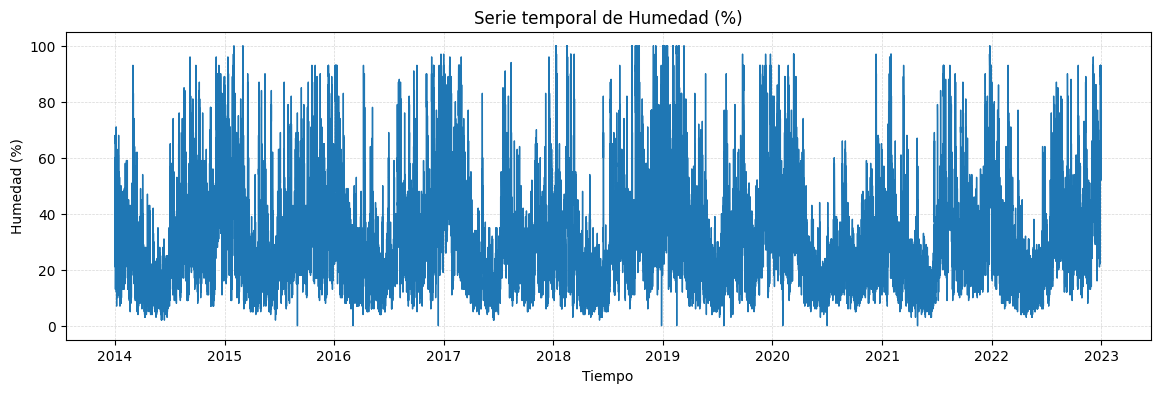

In [1973]:
# Creamos la gráfica de anchura 14, altura 4
fig, ax = plt.subplots(figsize=(14, 4))
# Pasamos las columnas que queremos representar
ax.plot(climaticos.index, climaticos['Humedad (%)'], linewidth=1)
# Nombre de la columna en el eje y
ax.set_ylabel('Humedad (%)')
# Nombre de la columna en el eje x
ax.set_xlabel('Tiempo')
# Nombre de la grafica
ax.set_title('Serie temporal de Humedad (%)')
# Grid de la gráfica
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
# Imprime la gráfica
plt.show()


Vemos en su serie tempora, cómo aquí parece que tampoco hay outliers, ya que no se ve un funcionamiento raro en ningún lado.

### Velocidad del viento (m/s)

Vamos a analizar esta variable.

In [1974]:
# Visualizamos minimo, maximo, media, desviación típica, 25%, 50%, 75% y el número de valores que tiene la variable
print(climaticos['Velocidad del viento (m/s)'].describe())

count    78888.000000
mean         2.884915
std          1.964542
min          0.000000
25%          1.341120
50%          2.682240
75%          3.576320
max         21.010880
Name: Velocidad del viento (m/s), dtype: float64


Se puede ver, que aunque por encima del 75% se dispara, no parece valores exagerados, por lo que vamos a analizar su serie temporal en la gráfica.

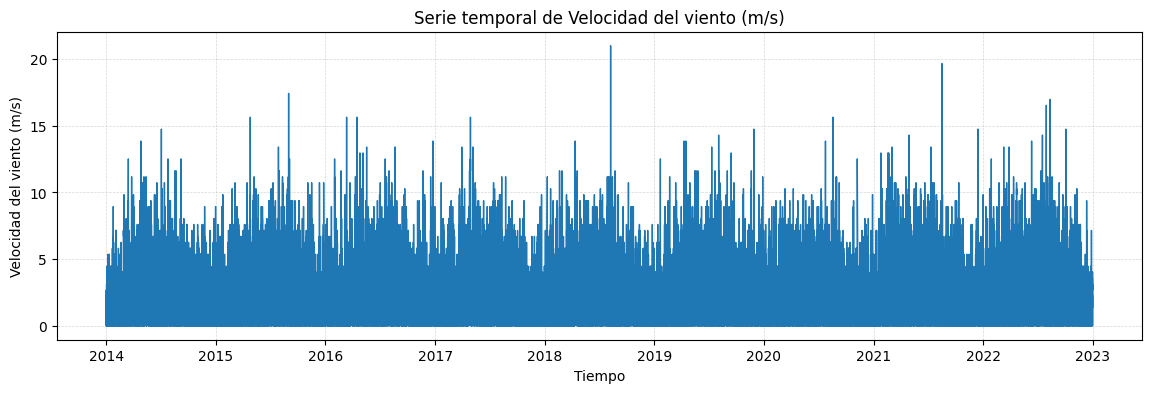

In [1975]:
# Creamos la gráfica de anchura 14, altura 4
fig, ax = plt.subplots(figsize=(14, 4))
# Pasamos las columnas que queremos representar
ax.plot(climaticos.index, climaticos['Velocidad del viento (m/s)'], linewidth=1)
# Nombre de la columna en el eje y
ax.set_ylabel('Velocidad del viento (m/s)')
# Nombre de la columna en el eje x
ax.set_xlabel('Tiempo')
# Nombre de la grafica
ax.set_title('Serie temporal de Velocidad del viento (m/s)')
# Grid de la gráfica
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
# Imprime la gráfica
plt.show()


Aquí se ve qué aunque hay subidas muy altas de viento, puede ser lógicas debido a borrascas, rachas de viento entre otras cosas (contexto de la variable) por lo que consideramos que no contiene outliers.

### Ráfaga de viento (m/s)

Vamos a analizar esta variable.

In [1976]:
# Visualizamos minimo, maximo, media, desviación típica, 25%, 50%, 75% y el número de valores que tiene la variable
print(climaticos['Ráfaga de viento (m/s)'].describe())

count    78888.000000
mean         0.650483
std          2.574001
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         28.163520
Name: Ráfaga de viento (m/s), dtype: float64


Puesto que la propia variable indica que son ráfagas, se puede ver como gran parte de los valores están situados en 0 y hay un valor máximo dentro de la lógica del contexto de la variable, por lo que no parecen haber outliers, vamos a analizar su serie temporal en una gráfica.

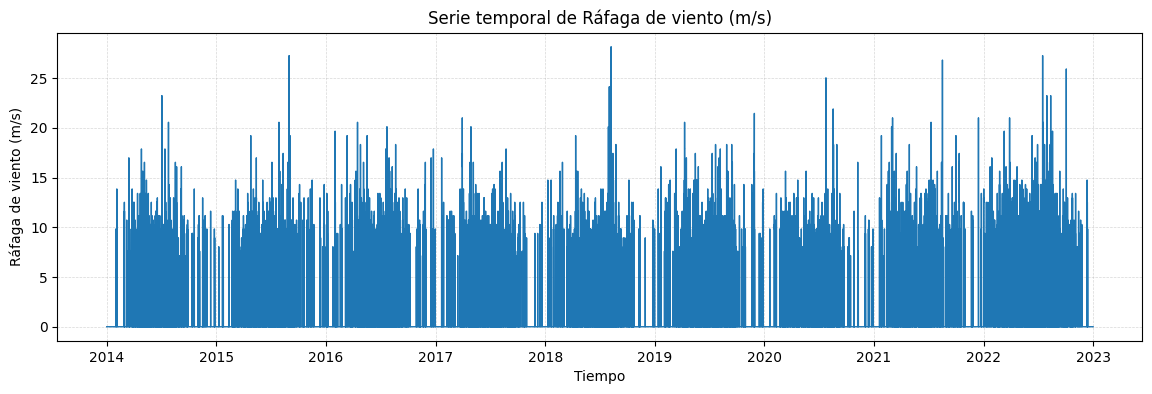

In [1977]:
# Creamos la gráfica de anchura 14, altura 4
fig, ax = plt.subplots(figsize=(14, 4))
# Pasamos las columnas que queremos representar
ax.plot(climaticos.index, climaticos['Ráfaga de viento (m/s)'], linewidth=1)
# Nombre de la columna en el eje y
ax.set_ylabel('Ráfaga de viento (m/s)')
# Nombre de la columna en el eje x
ax.set_xlabel('Tiempo')
# Nombre de la grafica
ax.set_title('Serie temporal de Ráfaga de viento (m/s)')
# Grid de la gráfica
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
# Imprime la gráfica
plt.show()


Cómo hemos descrito antes, al ser ráfagas, los valores estaran en 0 y habrán picos hacia arriba, que encima no son exagerados, por lo tanto lo consideramos normales dentro del contexto de la variable y decidimos no eliminar nada, puesto que no vemos outliers.

### Presión (hPa)

Vamos a analizar la variable.

In [1978]:
# Visualizamos minimo, maximo, media, desviación típica, 25%, 50%, 75% y el número de valores que tiene la variable
print(climaticos['Presión (hPa)'].describe())

count    78888.000000
mean       972.419750
std          7.531601
min          0.000000
25%        969.184818
50%        971.893930
75%        975.280320
max        991.534992
Name: Presión (hPa), dtype: float64


Por lo tanto decidimos eliminar únicamente las variables que bajen de 900 (hPa) de presión

In [1979]:
# Sustituimos los valores encima del 75% por nulos
climaticos['Presión (hPa)'] = climaticos['Presión (hPa)'].where((climaticos['Presión (hPa)'] >= 900)
)

Revisamos cuántos outliers hemos eliminado.

In [1980]:
# Visualizamos la cantidad de nulos que tiene el dataset
climaticos.isna().sum()

Día de la semana              0
Temperatura (°C)              0
Punto de rocío (°C)           0
Humedad (%)                   0
Dirección del viento          0
Velocidad del viento (m/s)    0
Ráfaga de viento (m/s)        0
Presión (hPa)                 3
Precipitación (mm)            0
Condición meteorológica       0
dtype: int64

Vemos como hemos eliminado 3 outliers. Ahora imputaremos a través de interpolación temporal.

In [1981]:
# Utilizamos interpolación temporal en el dataset en las columnas seleccionadas
climaticos['Presión (hPa)'] = climaticos['Presión (hPa)'].interpolate(method='time')

Revisamos de nuevo la variable.

In [1982]:
# Visualizamos minimo, maximo, media, desviación típica, 25%, 50%, 75% y el número de valores que tiene la variable
climaticos['Presión (hPa)'].describe()

count    78888.000000
mean       972.456865
std          4.556768
min        957.332453
25%        969.184818
50%        971.893930
75%        975.280320
max        991.534992
Name: Presión (hPa), dtype: float64

Se puede ver como ya no existen nulos ni valores extraños.

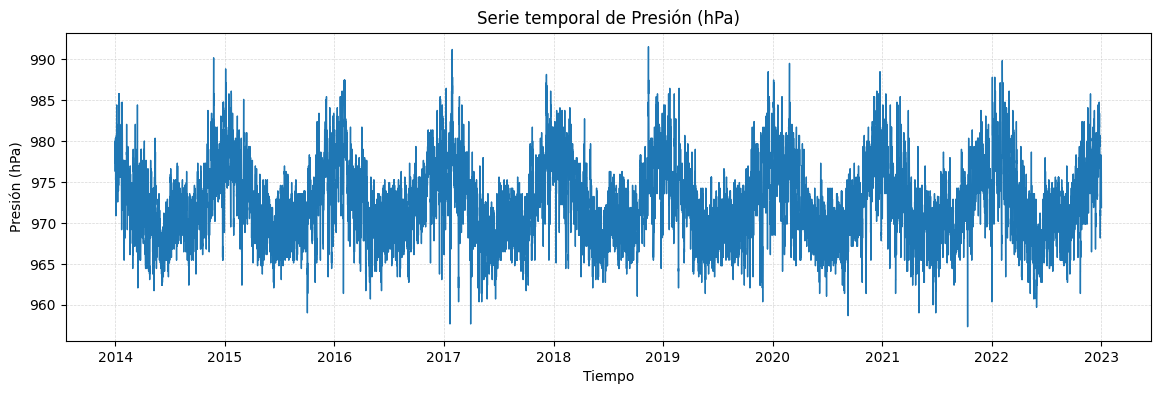

In [1983]:
# Creamos la gráfica de anchura 14, altura 4
fig, ax = plt.subplots(figsize=(14, 4))
# Pasamos las columnas que queremos representar
ax.plot(climaticos.index, climaticos['Presión (hPa)'], linewidth=1)
# Nombre de la columna en el eje y
ax.set_ylabel('Presión (hPa)')
# Nombre de la columna en el eje x
ax.set_xlabel('Tiempo')
# Nombre de la grafica
ax.set_title('Serie temporal de Presión (hPa)')
# Grid de la gráfica
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
# Imprime la gráfica
plt.show()


Se puede ver en la gráfica como ya se muestra la serie temporal de la variable sin problemas.

### Precipitación (mm)

Vamos a analizar esta variable.

In [1984]:
# Visualizamos minimo, maximo, media, desviación típica, 25%, 50%, 75% y el número de valores que tiene la variable
print(climaticos['Precipitación (mm)'].describe())

count    78888.000000
mean         0.017226
std          0.331767
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         25.400000
Name: Precipitación (mm), dtype: float64


Se puede ver cómo gran parte de los valores están en 0, rasgo característico de zonas muy poco lluviosas, por lo que los valores que están fuera de ellos son valores normales de que hay precipitación por lo tanto no lo consideramos outliers. Ahora vamos a revisar su serie temporal en la gráfica.

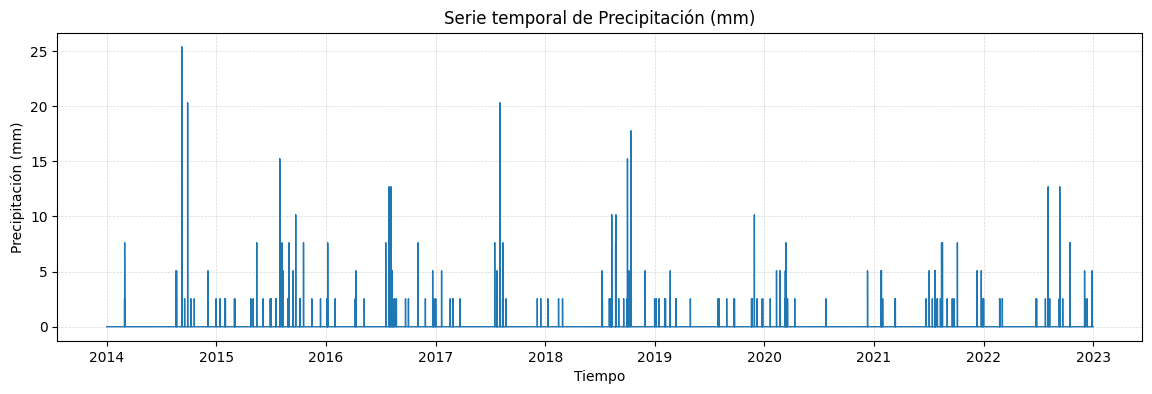

In [1985]:
# Creamos la gráfica de anchura 14, altura 4
fig, ax = plt.subplots(figsize=(14, 4))
# Pasamos las columnas que queremos representar
ax.plot(climaticos.index, climaticos['Precipitación (mm)'], linewidth=1)
# Nombre de la columna en el eje y
ax.set_ylabel('Precipitación (mm)')
# Nombre de la columna en el eje x
ax.set_xlabel('Tiempo')
# Nombre de la grafica
ax.set_title('Serie temporal de Precipitación (mm)')
# Grid de la gráfica
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
# Imprime la gráfica
plt.show()


Aquí se puede ver cómo efectivamente, su serie temporal demuestra el tiempo donde ha habido lluvia con precipitaciones dentro de valores razonables, por lo tanto no consideramos que esta variable tenga outliers.

# Transformación de variables categóricas a numéricas

In [1986]:
#Seleccionamos las columnas categóricas y las mostramos
categoricas = climaticos.select_dtypes(include = ["object"]).columns
categoricas

Index(['Dirección del viento', 'Condición meteorológica'], dtype='object')

In [1987]:
#Transformamos las categóricas a dummies, eliminando la primera columna de cada variable categórica, haciendo que desaparezca la colinealidad, combinación lineal de varias columnas para formar otra.
categoricas_Datos = pd.get_dummies(climaticos[categoricas], drop_first = True)
# Mostramos la transformación de las variables categóricas en variables dummies
categoricas_Datos.head()

Dirección del viento_E  Dirección del viento_ENE  \
2014-01-01 00:00:00                   False                     False   
2014-01-01 01:00:00                    True                     False   
2014-01-01 02:00:00                   False                     False   
2014-01-01 03:00:00                   False                     False   
2014-01-01 04:00:00                   False                     False   

                     Dirección del viento_ESE  Dirección del viento_N  \
2014-01-01 00:00:00                     False                   False   
2014-01-01 01:00:00                     False                   False   
2014-01-01 02:00:00                      True                   False   
2014-01-01 03:00:00                      True                   False   
2014-01-01 04:00:00                     False                   False   

                     Dirección del viento_NE  Dirección del viento_NNE  \
2014-01-01 00:00:00                    False                     False   
2014-01-01 01:00:00                    False                     False   
2014-01-01 02:00:00                    False                     False   
2014-01-01 03:00:00                    False                     False   
2014-01-01 04:00:00                    False                     False   

                     Dirección del viento_NNO  Dirección del viento_NO  \
2014-01-01 00:00:00                     False                    False   
2014-01-01 01:00:00                     False                    False   
2014-01-01 02:00:00                     False                    False   
2014-01-01 03:00:00                     False                    False   
2014-01-01 04:00:00                     False                    False   

                     Dirección del viento_O  Dirección del viento_ONO  ...  \
2014-01-01 00:00:00                   False                     False  ...   
2014-01-01 01:00:00                   False                     False  ...   
2014-01-01 02:00:00                   False                     False  ...   
2014-01-01 03:00:00                   False                     False  ...   
2014-01-01 04:00:00                   False                     False  ...   

                     Condición meteorológica_Neblina  \
2014-01-01 00:00:00                            False   
2014-01-01 01:00:00                            False   
2014-01-01 02:00:00                            False   
2014-01-01 03:00:00                            False   
2014-01-01 04:00:00                            False   

                     Condición meteorológica_Niebla  \
2014-01-01 00:00:00                           False   
2014-01-01 01:00:00                           False   
2014-01-01 02:00:00                           False   
2014-01-01 03:00:00                           False   
2014-01-01 04:00:00                           False   

                     Condición meteorológica_Nublado  \
2014-01-01 00:00:00                            False   
2014-01-01 01:00:00                            False   
2014-01-01 02:00:00                            False   
2014-01-01 03:00:00                            False   
2014-01-01 04:00:00                            False   

                     Condición meteorológica_Parcialmente_nublado  \
2014-01-01 00:00:00                                         False   
2014-01-01 01:00:00                                         False   
2014-01-01 02:00:00                                         False   
2014-01-01 03:00:00                                         False   
2014-01-01 04:00:00                                         False   

                     Condición meteorológica_Patches  \
2014-01-01 00:00:00                            False   
2014-01-01 01:00:00                            False   
2014-01-01 02:00:00                            False   
2014-01-01 03:00:00                            False   
2014-01-01 04:00:00                            False   

                     Condic

In [1988]:
# Eliminamos los atributos originales
climaticos.drop(categoricas, axis = 1, inplace = True)
# Concatenamos los nuevos atributos creados para las variables categóricas
energia_climaticos = pd.concat([climaticos, categoricas_Datos], axis = 1)
# Mostramos como quedan los datos de nuevo
energia_climaticos.head()

Día de la semana  Temperatura (°C)  Punto de rocío (°C)  \
2014-01-01 00:00:00                 2         11.666667           -17.777778   
2014-01-01 01:00:00                 2         10.555556             0.555556   
2014-01-01 02:00:00                 2         10.000000           -17.777778   
2014-01-01 03:00:00                 2          9.444444           -17.777778   
2014-01-01 04:00:00                 2          9.444444           -17.777778   

                     Humedad (%)  Velocidad del viento (m/s)  \
2014-01-01 00:00:00         45.0                     0.00000   
2014-01-01 01:00:00         50.0                     2.23520   
2014-01-01 02:00:00         50.0                     1.34112   
2014-01-01 03:00:00         52.0                     2.68224   
2014-01-01 04:00:00         52.0                     0.00000   

                     Ráfaga de viento (m/s)  Presión (hPa)  \
2014-01-01 00:00:00                     0.0     977.312154   
2014-01-01 01:00:00                     0.0     977.312154   
2014-01-01 02:00:00                     0.0     977.312154   
2014-01-01 03:00:00                     0.0     977.312154   
2014-01-01 04:00:00                     0.0     977.650793   

                     Precipitación (mm)  Dirección del viento_E  \
2014-01-01 00:00:00                 0.0                   False   
2014-01-01 01:00:00                 0.0                    True   
2014-01-01 02:00:00                 0.0                   False   
2014-01-01 03:00:00                 0.0                   False   
2014-01-01 04:00:00                 0.0                   False   

                     Dirección del viento_ENE  ...  \
2014-01-01 00:00:00                     False  ...   
2014-01-01 01:00:00                     False  ...   
2014-01-01 02:00:00                     False  ...   
2014-01-01 03:00:00                     False  ...   
2014-01-01 04:00:00                     False  ...   

                     Condición meteorológica_Neblina  \
2014-01-01 00:00:00                            False   
2014-01-01 01:00:00                            False   
2014-01-01 02:00:00                            False   
2014-01-01 03:00:00                            False   
2014-01-01 04:00:00                            False   

                     Condición meteorológica_Niebla  \
2014-01-01 00:00:00                           False   
2014-01-01 01:00:00                           False   
2014-01-01 02:00:00                           False   
2014-01-01 03:00:00                           False   
2014-01-01 04:00:00                           False   

                     Condición meteorológica_Nublado  \
2014-01-01 00:00:00                            False   
2014-01-01 01:00:00                            False   
2014-01-01 02:00:00                            False   
2014-01-01 03:00:00                            False   
2014-01-01 04:00:00                            False   

                     Condición meteorológica_Parcialmente_nublado  \
2014-01-01 00:00:00                                         False   
2014-01-01 01:00:00                                         False   
2014-01-01 02:00:00                                         False   
2014-01-01 03:00:00                                         False   
2014-01-01 04:00:00                                         False   

                     Condición meteorológica_Patches  \
2014-01-01 00:00:00                            False   
2014-01-01 01:00:00                            False   
2014-01-01 02:00:00                            False   
2014-01-01 03:00:00                            False   
2014-01-01 04:00:00                            False   

                     Condición meteorológica_Smoke  \
2014-01-01 00:00:00                          False   
2014-01-01 01:00:00                          False   
2014-01-01 02:00:00                          False   
2014-01-01 03:00:00                          False   
2014-01-01 04:00:00        

# Uso de IA

**Prompt:** pero pierde puntos del eje x, como lo hago para poner todos los meses?

**Respuesta:**
```Python
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Selección de rango
ts = energia_mensual["2014":"2015"]

# Crear la figura
fig, ax = plt.subplots(figsize=(12,4))

# Graficar línea principal
ax.plot(ts.index, ts.values, marker='o', color='blue', label='Consumo mensual')

# Resaltar el pico de cada año
for year in ts.index.year.unique():
    pico = ts[ts.index.year == year].idxmax()
    ax.scatter(pico, ts[pico], color='red', zorder=5)
    ax.text(pico, ts[pico]+0.1, str(pico.month), ha='center', color='red')

# Título y etiquetas
ax.set_title("Consumo medio mensual (2014-2015) con picos estacionales")
ax.set_xlabel("Mes")
ax.set_ylabel("Electricidad (kW)")

# Grid
ax.grid(color='gray', linestyle='--', linewidth=0.7)

# Configurar eje X para mostrar todos los meses
ax.xaxis.set_major_locator(mdates.MonthLocator())  # cada mes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotar etiquetas para que no se superpongan
plt.xticks(rotation=45)

# Leyenda
ax.legend()

plt.tight_layout()
plt.show()
```


**Prompt:** hazme una tabla de correlacion de todas las columnas de un conjunto de datos en python

**Respuesta:**
```Python
import pandas as pd

# Cargar tu conjunto de datos
# Por ejemplo, si es un CSV:
df = pd.read_csv("ruta/a/tu/archivo.csv")

# Crear la tabla de correlación
correlation_matrix = df.corr()

# Mostrar la tabla de correlación
print(correlation_matrix)

# Opcional: si quieres visualizarla de forma más atractiva con un heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()
```